<h1 style="font-family:Corbel Light; color:#97a9fd">Projet 7 : Implémentez un modèle de scoring </h1>

<h2 style="font-family:Corbel Light; color:#737373"><span style="color:#97a9fd">Étape 1</span> : Algorithme de classification </h2>

<h3 style="font-family:Corbel Light; color:#737373">Requirements</h3>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

import toolbox
import shap
import gc

import time
from time import perf_counter

from contextlib import contextmanager

import lightgbm
from lightgbm import LGBMClassifier

import sklearn 
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, accuracy_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.base import TransformerMixin
from sklearn.utils import resample, class_weight
from sklearn import set_config

import xgboost as xgb
import catboost as ctb

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn

import imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier

import logging
from enum import Enum

import hyperopt
from hyperopt import fmin, hp, tpe, Trials
from hyperopt.early_stop import no_progress_loss
from hyperopt.pyll import scope
from math import ceil
from functools import partial

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
python_version = !python -V
print('python version :', python_version, '\n')
print('pandas version : ', pd.__version__, '\n')
print('numpy version : ', np.__version__, '\n')
print('matplotlib version : ', matplotlib.__version__, '\n')
print('seaborn version : ', sns.__version__, '\n')
print('sci-kit learn version : ', sklearn.__version__, '\n')
print('lightgbm version : ', lightgbm.__version__, '\n')
print('mlflow version : ', mlflow.__version__, '\n')
print('imblearn version :', imblearn.__version__, '\n')

python version : ['Python 3.9.12'] 

pandas version :  1.4.2 

numpy version :  1.22.4 

matplotlib version :  3.7.1 

seaborn version :  0.12.2 

sci-kit learn version :  1.2.1 

lightgbm version :  3.3.5 

mlflow version :  2.3.2 

imblearn version : 0.10.1 



**Versions utilisées :**

- python : Python 3.9.12 
- seaborn    :  0.12.1
- matplotlib :  3.7.1 
- numpy  :  1.23.5 
- pandas :  1.4.2
- sklearn :  1.2.1
- lightgbm : 3.3.5
- mlflow : 2.3.2
- imbalanced-learn : 0.10.1

In [53]:
import importlib
import toolbox
toolbox = importlib.reload(toolbox) 

<h3 style="font-family:Corbel Light; color:#737373">Analyse Exploratoire</h3>

https://www.kaggle.com/c/home-credit-default-risk/data

Nous avons 10 fichiers contenant : 
- les demandes de crédit déposée auprès de la société Prêt à dépenser
    - jeu de test (121 colonnes)
    - jeu d'entrainement(121 colonnes + cible : 1 crédit accordé, 0 refusé)
- les demandes de crédit adressées à d'autres institutions financières et recensées par le bureau de crédit
- les mensualités associées aux crédits accordés et recensés par le bureau de crédit
- échéancier des mensualités associées aux prêts à la consommation (accordés par d'autres institutions financières)
- échéancier des mensualités associées aux prêts adossés à une carte de crédit (accordés par d'autres institutions financières)
- les demandes de crédits acceptées par Home Credit
- écheancier des crédits accordés par Home Credit
- des examples de résultat de classification
- la description des variables de tous ces jeux de données

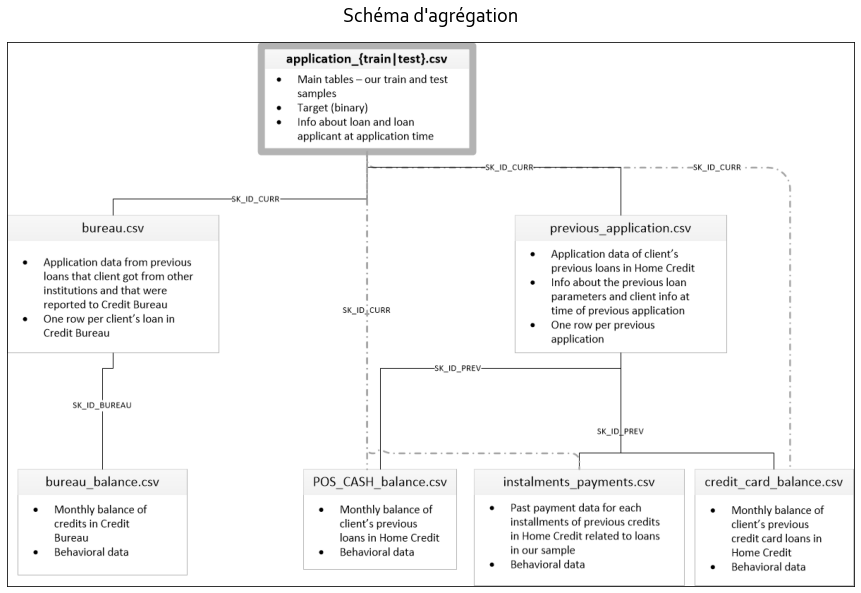

In [4]:
url = 'https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png'
toolbox.display_image_from_url(url, 'Schéma d\'agrégation', (20, 10))

<h4 style="font-family:Corbel Light; color:#737373">Demandes de crédit auprès de la société "Prêt à dépenser" - jeu d'entraînement</h4>

In [19]:
application_train = pd.read_csv('application_train.csv')
application_train.shape

(307511, 122)

Regardons les 5 premières lignes du jeu de données :

In [6]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Regardons la structure du jeu de données :

In [7]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


Regardons si le jeu de données contient des variables catégorielles

In [40]:
categorical_columns_train = [col for col in application_train.columns if application_train[col].dtype == 'object']

In [41]:
categorical_columns_train

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

Il semblerait que 'SK_ID_CURR' soit la clé primaire de ce jeu de données (on a bien une valeur différente pour chacun des 307_511 individus). 

Cette variable correspond à l'identifiant de chaque demande de crédit faite auprès de la société 'Prêt à dépenser' (ID of loan in our sample).

In [8]:
application_train.nunique().sort_values(ascending=False)

SK_ID_CURR            307511
EXT_SOURCE_2          119831
EXT_SOURCE_1          114584
DAYS_BIRTH             17460
DAYS_REGISTRATION      15688
                       ...  
NAME_CONTRACT_TYPE         2
FLAG_DOCUMENT_2            2
FLAG_DOCUMENT_3            2
FLAG_DOCUMENT_4            2
FLAG_OWN_REALTY            2
Length: 122, dtype: int64

Regardons si le jeu de données contient des doublons :

In [9]:
application_train.drop(columns=['SK_ID_CURR']).duplicated().sum() 

0

Vérifions qu'il ne manque pas de valeurs dans la colonne 'TARGET':

In [71]:
train_missing_df = toolbox.missing_values_by_column(application_train)
train_missing_df.loc[train_missing_df['VARIABLES']=='TARGET']

,VARIABLES,Number of Missing Values,Missing Values (%)
1,TARGET,0,0.0


Regardons s'il manque beaucoup de valeurs dans les autres colonne: 
il manque des valeurs pour 67 des 122 variables du jeu de données.

In [10]:
train_missing_df = train_missing_df.loc[train_missing_df['Number of Missing Values'] > 0]
train_missing_df

,VARIABLES,Number of Missing Values,Missing Values (%)
95,DAYS_LAST_PHONE_CHANGE,1,0.00
29,CNT_FAM_MEMBERS,2,0.00
9,AMT_ANNUITY,12,0.00
10,AMT_GOODS_PRICE,278,0.09
42,EXT_SOURCE_2,660,0.21
...,...,...,...
84,NONLIVINGAPARTMENTS_MEDI,213514,69.43
70,NONLIVINGAPARTMENTS_MODE,213514,69.43
62,COMMONAREA_MODE,214865,69.87
48,COMMONAREA_AVG,214865,69.87


Dans le kernel Kaggle utilisé pour nettoyer nos données, 
- les individus pour lesquels la variable 'CODE_GENDER' est égale à 'XNA' sont supprimés
- les individus pour lesquels la variable 'DAYS_EMPLOYED' est égale à 365243 sont remplacés par des nan

Regardons si ces incohérences se trouvent aussi dans notre jeu de données.

In [11]:
application_train['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [12]:
application_train[application_train['CODE_GENDER'] == 'XNA']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
35657,141289,0,Revolving loans,XNA,Y,Y,0,207000.0,382500.0,19125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
38566,144669,0,Revolving loans,XNA,N,Y,2,157500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,3.0,0.0,4.0
83382,196708,0,Revolving loans,XNA,N,Y,1,135000.0,405000.0,20250.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
189640,319880,0,Revolving loans,XNA,Y,Y,0,247500.0,540000.0,27000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,6.0


In [13]:
application_train.loc[application_train['DAYS_EMPLOYED']==365243][['DAYS_EMPLOYED']]

,DAYS_EMPLOYED
8,365243
11,365243
23,365243
38,365243
43,365243
...,...
307469,365243
307483,365243
307487,365243
307505,365243


Regardons la cible :

Très fort déséquilibre de classe dans ce jeu de données, avec 92% de crédits accordés et 8% de demandes refusées.

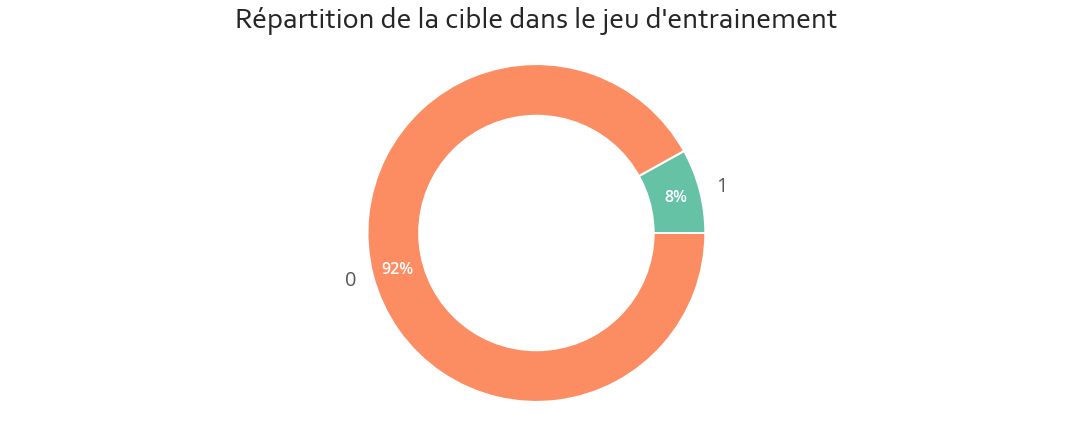

In [14]:
toolbox.plot_donut(application_train, 'TARGET','Répartition de la cible dans le jeu d\'entrainement', (15, 6))

In [22]:
application_train.describe(include=np.number)['EXT_SOURCE_1']

count    134133.000000
mean          0.502130
std           0.211062
min           0.014568
25%           0.334007
50%           0.505998
75%           0.675053
max           0.962693
Name: EXT_SOURCE_1, dtype: float64

<h4 style="font-family:Corbel Light; color:#737373">Demandes de crédit auprès de la société "Prêt à dépenser" - jeu de test</h4>

In [42]:
application_test = pd.read_csv('application_test.csv')
application_test.shape

(48744, 121)

Regardons les 5 premières lignes du jeu de données :

In [16]:
application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Regardons la structure du jeu de données : pas de variable 'TARGET' dans le jeu de test

In [17]:
application_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


Regardons les variables catégorielles :

In [44]:
categorical_columns_test = [col for col in application_test.columns if application_test[col].dtype == 'object']
categorical_columns_test

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

Comme pour le jeu d'entraînement, la variable 'SK_ID_CURR' est la clé primaire de ce jeu de données.

In [18]:
application_test.nunique().sort_values(ascending=False)

SK_ID_CURR           48744
EXT_SOURCE_2         38885
EXT_SOURCE_1         27207
DAYS_BIRTH           15477
DAYS_REGISTRATION    12618
                     ...  
FLAG_DOCUMENT_14         1
FLAG_DOCUMENT_13         1
FLAG_DOCUMENT_12         1
FLAG_DOCUMENT_10         1
FLAG_DOCUMENT_15         1
Length: 121, dtype: int64

Regardons si ce jeu contient des doublons :

In [19]:
application_test.drop(columns=['SK_ID_CURR']).duplicated().sum() 

0

Regardons les valeurs manquantes : il manque des valeurs dans 64 des 121 variables du jeu de données.

In [20]:
test_missing_df = toolbox.missing_values_by_column(application_test)
test_missing_df = test_missing_df.loc[test_missing_df['Number of Missing Values'] > 0]
test_missing_df

,VARIABLES,Number of Missing Values,Missing Values (%)
41,EXT_SOURCE_2,8,0.02
8,AMT_ANNUITY,24,0.05
91,DEF_30_CNT_SOCIAL_CIRCLE,29,0.06
93,DEF_60_CNT_SOCIAL_CIRCLE,29,0.06
92,OBS_60_CNT_SOCIAL_CIRCLE,29,0.06
...,...,...,...
83,NONLIVINGAPARTMENTS_MEDI,33347,68.41
69,NONLIVINGAPARTMENTS_MODE,33347,68.41
61,COMMONAREA_MODE,33495,68.72
47,COMMONAREA_AVG,33495,68.72


Les variables qui contiennent des données manquantes dans le jeu de test en contiennent également dans le jeu d'entraînement.

In [21]:
test_missing_df['VARIABLES'].isin(train_missing_df['VARIABLES']).value_counts()

True    64
Name: VARIABLES, dtype: int64

3 variables contiennent des données manquantes dans le jeu d'entraînement mais pas dans le jeu de test.

In [22]:
train_missing_df.loc[~train_missing_df['VARIABLES'].isin(test_missing_df['VARIABLES'])]

,VARIABLES,Number of Missing Values,Missing Values (%)
95,DAYS_LAST_PHONE_CHANGE,1,0.00
29,CNT_FAM_MEMBERS,2,0.00
10,AMT_GOODS_PRICE,278,0.09


Comme pour le jeu d'entraînement, regardons si le nettoyage est justifié :

In [23]:
application_test['CODE_GENDER'].unique()

array(['F', 'M'], dtype=object)

In [24]:
application_test.loc[application_test['DAYS_EMPLOYED']==365243][['DAYS_EMPLOYED']]

,DAYS_EMPLOYED
10,365243
17,365243
22,365243
26,365243
36,365243
...,...
48717,365243
48728,365243
48731,365243
48735,365243


<h4 style="font-family:Corbel Light; color:#737373">Demandes de crédit faites auprès d'autres institutions financières recensées par le bureau de crédit</h4>

Bureau de crédit = un service qui permet à un prêteur de connaitre la solvabilité d'un emprunteur en fournissant un rapport de crédit au sujet de cette personne.

In [25]:
bureau = pd.read_csv('bureau.csv')
bureau.shape

(1716428, 17)

Regardons les 5 premières lignes :

In [26]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


Regardons la structure du jeu de données :

In [27]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


La clé primaire de ce jeu de données est 'SK_ID_BUREAU'(on a autant de valeurs différentes que de lignes).

SK_ID_BUREAU = Recorded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)

Donc on a une ligne par ancien prêt et une même demande de crédit faite auprès de la société Pret à dépenser (SK_ID_CURR) peut correspondre à plusieurs anciens prêts.

In [28]:
bureau.nunique().sort_values(ascending=False)

SK_ID_BUREAU              1716428
SK_ID_CURR                 305811
AMT_CREDIT_SUM             236708
AMT_CREDIT_SUM_DEBT        226537
AMT_CREDIT_MAX_OVERDUE      68251
AMT_CREDIT_SUM_LIMIT        51726
AMT_ANNUITY                 40321
DAYS_CREDIT_ENDDATE         14096
DAYS_CREDIT_UPDATE           2982
DAYS_CREDIT                  2923
DAYS_ENDDATE_FACT            2917
AMT_CREDIT_SUM_OVERDUE       1616
CREDIT_DAY_OVERDUE            942
CREDIT_TYPE                    15
CNT_CREDIT_PROLONG             10
CREDIT_CURRENCY                 4
CREDIT_ACTIVE                   4
dtype: int64

Regardons si le jeu de données contient des doublons : oui car un même client peut avoir souscrit plusieurs prêts avec les mêmes caractéristiques.

In [29]:
bureau.drop(columns=['SK_ID_BUREAU']).duplicated().sum()

2059

Regardons s'il manque des valeurs :

In [30]:
bureau_missing_df = toolbox.missing_values_by_column(bureau)
bureau_missing_df = bureau_missing_df.loc[bureau_missing_df['Number of Missing Values'] > 0]
bureau_missing_df

,VARIABLES,Number of Missing Values,Missing Values (%)
10,AMT_CREDIT_SUM,13,0.00
6,DAYS_CREDIT_ENDDATE,105553,6.15
11,AMT_CREDIT_SUM_DEBT,257669,15.01
12,AMT_CREDIT_SUM_LIMIT,591780,34.48
7,DAYS_ENDDATE_FACT,633653,36.92
8,AMT_CREDIT_MAX_OVERDUE,1124488,65.51
16,AMT_ANNUITY,1226791,71.47


<h4 style="font-family:Corbel Light; color:#737373">Mensualités recensées par le bureau de crédit</h4>

In [31]:
bureau_balance = pd.read_csv('bureau_balance.csv')
bureau_balance.shape

(27299925, 3)

Regardons les 5 premières lignes : 

In [32]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Regardons la structure du jeu de données : 

In [33]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


Regardons le nombre de valeurs différentes que peut prendre chacune des variables :

In [34]:
bureau_balance.nunique().sort_values(ascending=False)

SK_ID_BUREAU      817395
MONTHS_BALANCE        97
STATUS                 8
dtype: int64

La clé primaire du jeu de données est la combinaison des deuxc variables 'SK_ID_BUREAU' et 'MONTHS_BALANCE', car on peut avoir plusieurs mensualités par prêt.

MONTH_BALANCE = Month of balance relative to application date (-1 means the freshest balance date)

In [35]:
bureau_balance.loc[bureau_balance.duplicated(subset=['SK_ID_BUREAU', 'MONTHS_BALANCE'])].shape[0]

0

Il n'y a pas de doublons

In [36]:
bureau_balance.duplicated().sum()

0

Il n'y a aucune valeur manquante

In [37]:
bureau_balance.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

<h4 style="font-family:Corbel Light; color:#737373">Mensualités associées aux prêts à la consommation déjà accordés par la société "Prêt à dépenser"</h4>

In [38]:
pos = pd.read_csv('POS_CASH_balance.csv')
pos.shape

(10001358, 8)

In [39]:
pos.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


Regardons la structure du jeu de données :

In [40]:
pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


Regardons le nombre de valeurs différentes que peut prendre chaque variable :

In [41]:
pos.nunique().sort_values(ascending=False)

SK_ID_PREV               936325
SK_ID_CURR               337252
SK_DPD                     3400
SK_DPD_DEF                 2307
MONTHS_BALANCE               96
CNT_INSTALMENT_FUTURE        79
CNT_INSTALMENT               73
NAME_CONTRACT_STATUS          9
dtype: int64

La clé primaire du jeu de données semble être la combinaison des variables 'SK_ID_PREV' et 'MONTHS_BALANCE'. Chaque individu de ce jeu de donnée correspond à une mensualité d'un ancien crédit à la consommation.

'SK_ID_PREV' = ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)

In [42]:
pos.loc[pos.duplicated(subset=['SK_ID_PREV', 'MONTHS_BALANCE'])].shape[0]

0

Aucun doublon :

In [43]:
pos.duplicated().sum()

0

Il manque des valeurs dans deux variables : 'CNT_INSTALMENT' et 'CNT_INSTALMENT_FUTURE' :
- CNT_INSTALMENT : nombre total de mensualités
- CNT_INSTALMENT_FUTURE : nombre de mensualités restantes

In [44]:
pos.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

<h4 style="font-family:Corbel Light; color:#737373"> Mensualités associées à la carte de crédit (credit card loan) </h4>

In [45]:
credit_card_balance = pd.read_csv('credit_card_balance.csv')
credit_card_balance.shape

(3840312, 23)

Regardons les 5 premières lignes :

In [46]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


Regardons la structure du jeu de données :

In [47]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

Regardons le nombre de valeurs différentes que peut prendre chaque variable

In [48]:
credit_card_balance.nunique().sort_values(ascending=False)

AMT_BALANCE                   1347904
AMT_TOTAL_RECEIVABLE          1339008
AMT_RECIVABLE                 1338878
AMT_RECEIVABLE_PRINCIPAL      1195839
AMT_INST_MIN_REGULARITY        312266
AMT_DRAWINGS_CURRENT           187005
AMT_PAYMENT_TOTAL_CURRENT      182957
AMT_DRAWINGS_POS_CURRENT       168748
AMT_PAYMENT_CURRENT            163209
SK_ID_PREV                     104307
SK_ID_CURR                     103558
AMT_DRAWINGS_ATM_CURRENT         2267
AMT_DRAWINGS_OTHER_CURRENT       1832
SK_DPD                            917
SK_DPD_DEF                        378
AMT_CREDIT_LIMIT_ACTUAL           181
CNT_DRAWINGS_POS_CURRENT          133
CNT_DRAWINGS_CURRENT              129
CNT_INSTALMENT_MATURE_CUM         121
MONTHS_BALANCE                     96
CNT_DRAWINGS_ATM_CURRENT           44
CNT_DRAWINGS_OTHER_CURRENT         11
NAME_CONTRACT_STATUS                7
dtype: int64

La clé primaire de cette table semble être la combinaison des deux variables 'SK_ID_PREV' et 'MONTHS_BALANCE'. Donc chaque ligne correspond à une mensualité adossée à une carte de crédit.

- SK_ID_PREV = ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
- MONTHS_BALANCE = Month of balance relative to application date (-1 means the freshest balance date)

In [49]:
credit_card_balance.loc[credit_card_balance.duplicated(subset=['SK_ID_PREV', 'MONTHS_BALANCE'])].shape[0]

0

Aucun doublon :

In [50]:
credit_card_balance.duplicated().sum()

0

Regardons s'il manque des valeurs : il manque des valeurs dans 9 des 23 colonnes.

In [51]:
credit_card_missing_df = toolbox.missing_values_by_column(credit_card_balance)
credit_card_missing_df.loc[credit_card_missing_df['Number of Missing Values'] > 0]

,VARIABLES,Number of Missing Values,Missing Values (%)
9,AMT_INST_MIN_REGULARITY,305236,7.95
19,CNT_INSTALMENT_MATURE_CUM,305236,7.95
8,AMT_DRAWINGS_POS_CURRENT,749816,19.52
5,AMT_DRAWINGS_ATM_CURRENT,749816,19.52
15,CNT_DRAWINGS_ATM_CURRENT,749816,19.52
17,CNT_DRAWINGS_OTHER_CURRENT,749816,19.52
18,CNT_DRAWINGS_POS_CURRENT,749816,19.52
7,AMT_DRAWINGS_OTHER_CURRENT,749816,19.52
10,AMT_PAYMENT_CURRENT,767988,20.00


<h4 style="font-family:Corbel Light; color:#737373">Anciennes demandes de crédit faites auprès de la société "Prêt à dépenser"</h4>

In [102]:
previous_application = pd.read_csv('previous_application.csv')
previous_application.shape

(1670214, 37)

Regardons les 5 premières lignes :

In [53]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


Regardons la structure du jeu de données

In [54]:
previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

Regardons le nombre de valeurs différentes que peut prendre chaque variables :

La variable 'SK_ID_PREV' semble être la clé primaire de ce jeu de données. Chaque ligne correspond à une demande de crédit faite auprès de Home Credit (qui n'a pas forcément été acceptée).

In [55]:
previous_application.nunique()

SK_ID_PREV                     1670214
SK_ID_CURR                      338857
NAME_CONTRACT_TYPE                   4
AMT_ANNUITY                     357959
AMT_APPLICATION                  93885
AMT_CREDIT                       86803
AMT_DOWN_PAYMENT                 29278
AMT_GOODS_PRICE                  93885
WEEKDAY_APPR_PROCESS_START           7
HOUR_APPR_PROCESS_START             24
FLAG_LAST_APPL_PER_CONTRACT          2
NFLAG_LAST_APPL_IN_DAY               2
RATE_DOWN_PAYMENT               207033
RATE_INTEREST_PRIMARY              148
RATE_INTEREST_PRIVILEGED            25
NAME_CASH_LOAN_PURPOSE              25
NAME_CONTRACT_STATUS                 4
DAYS_DECISION                     2922
NAME_PAYMENT_TYPE                    4
CODE_REJECT_REASON                   9
NAME_TYPE_SUITE                      7
NAME_CLIENT_TYPE                     4
NAME_GOODS_CATEGORY                 28
NAME_PORTFOLIO                       5
NAME_PRODUCT_TYPE                    3
CHANNEL_TYPE             

Regardons s'il manque des valeurs : il manque des valeurs dans 16 des 37 colonnes 

In [56]:
previous_application_missing_df = toolbox.missing_values_by_column(previous_application)
previous_application_missing_df.loc[previous_application_missing_df['Number of Missing Values'] > 0]

,VARIABLES,Number of Missing Values,Missing Values (%)
5,AMT_CREDIT,1,0.00
30,PRODUCT_COMBINATION,346,0.02
28,CNT_PAYMENT,372230,22.29
3,AMT_ANNUITY,372235,22.29
7,AMT_GOODS_PRICE,385515,23.08
34,DAYS_LAST_DUE,673065,40.30
33,DAYS_LAST_DUE_1ST_VERSION,673065,40.30
32,DAYS_FIRST_DUE,673065,40.30
31,DAYS_FIRST_DRAWING,673065,40.30
36,NFLAG_INSURED_ON_APPROVAL,673065,40.30


In [103]:
previous_application.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


<h4 style="font-family:Corbel Light; color:#737373">Echeancier des crédits déjà accordés</h4>

une ligne = un versement. On peut donc avoir plusieurs lignes pour un même crédit, si le client rembourse en plusieurs fois.

In [39]:
installments_payments = pd.read_csv('installments_payments.csv')
installments_payments.shape

(13605401, 8)

Regardons les 5 premières lignes :

In [58]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


Regardons la structure du jeu de données

In [59]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


Regardons le nombre de valeurs différentes que peut prendre chaque variable :

In [60]:
installments_payments.nunique()

SK_ID_PREV                997752
SK_ID_CURR                339587
NUM_INSTALMENT_VERSION        65
NUM_INSTALMENT_NUMBER        277
DAYS_INSTALMENT             2922
DAYS_ENTRY_PAYMENT          3039
AMT_INSTALMENT            902539
AMT_PAYMENT               944235
dtype: int64

Aucun doublon :

In [61]:
installments_payments.duplicated().sum()

0

Regardons s'il manque des valeurs : 

In [62]:
installments_payments.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

In [47]:
installments_payments.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,PAYMENT_PERC
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07,13602494.0
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04,inf
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04,NaN
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00,0.0
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03,1.0
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03,1.0
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04,1.0
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06,inf


Problème ratio : ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']

In [49]:
%%time
installments_payments['PAYMENT_PERC'] = installments_payments['AMT_PAYMENT']/installments_payments['AMT_INSTALMENT']
installments_payments[np.isinf(installments_payments['PAYMENT_PERC'])] = 0

In [51]:
installments_payments.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,PAYMENT_PERC
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07,1.360249e+07
mean,1.903330e+06,2.784396e+05,8.566191e-01,1.887060e+01,-1.042235e+03,-1.051081e+03,1.705091e+04,1.723775e+04,1.278327e+00
std,5.362604e+05,1.027244e+05,1.035221e+00,2.666410e+01,8.009438e+02,8.005848e+02,5.057025e+04,5.473528e+04,1.328507e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434165e+06,1.896370e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.397815e+03,1.000000e+00
50%,1.896503e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125245e+03,1.000000e+00
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610752e+04,1.000000e+00
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,0.000000e+00,0.000000e+00,3.771488e+06,3.771488e+06,1.942500e+05


In [77]:
del installments_payments
gc.collect()

1900

<h4 style="font-family:Corbel Light; color:#737373">Exemple de résultat classification</h4>

In [63]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.shape

(48744, 2)

Regardons les 5 premières lignes :

In [64]:
sample_submission.head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


Regardons la structure du jeu de données :

In [65]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB


La clé primaire de ce jeu de données est 'SK_ID_CURR' (identifiant de la demande de crédit déposée auprès de la société 'Prêt à dépenser').

In [66]:
sample_submission.nunique()

SK_ID_CURR    48744
TARGET            1
dtype: int64

Regardons s'il manque des valeurs :

In [67]:
sample_submission.isnull().sum()

SK_ID_CURR    0
TARGET        0
dtype: int64

<h3 style="font-family:Corbel Light; color:#737373">Fonctions</h3>

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [87]:
def preprocess_application_data(file_path: str, num_rows = None):
    """
    Nettoie un jeu de données contenant les demandes de crédits auprès de la société 'Prêt à dépenser' 
    et crée de nouvelles variables.
    
    Positional arguments : 
    -------------------------------------
    file_path : str : emplacement du fichier contenant le jeu de données
    
    Optional arguments : 
    -------------------------------------
    num_rows : int : taille des échantillons train et test (si None, garde les jeux de données entiers)
    """

    dataset = pd.read_csv(file_path, nrows= num_rows)
    
    # Nettoyage : 
    #Supprime les lignes pour lesquelles la variables CODE_GENDER n'est ni F ni M
    #Remplace variables DAYS_EMPLOYED = 365243 par nan
    
    dataset = dataset[dataset['CODE_GENDER'].isin(['F', 'M'])]
    dataset['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    # Feature engineering : ajout de pourcentages
    dataset['DAYS_EMPLOYED_PERC'] = dataset['DAYS_EMPLOYED'] / dataset['DAYS_BIRTH']
    dataset['INCOME_CREDIT_PERC'] = dataset['AMT_INCOME_TOTAL'] / dataset['AMT_CREDIT']
    dataset['INCOME_PER_PERSON'] = dataset['AMT_INCOME_TOTAL'] / dataset['CNT_FAM_MEMBERS']
    dataset['ANNUITY_INCOME_PERC'] = dataset['AMT_ANNUITY'] / dataset['AMT_INCOME_TOTAL']
    dataset['PAYMENT_RATE'] = dataset['AMT_ANNUITY'] / dataset['AMT_CREDIT']
    
    for col_percentage in ['DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE']:
        dataset[np.isinf(dataset[col_percentage])] = 0
    
    return dataset

In [64]:
def preprocess_bureau_and_balance(bureau_file_path: str, balance_file_path: str, save=True):
    """
    Agrège les lignes de bureau_balance.csv (données mensuelles) par identifiant de demande de prêt 'SK_ID_BUREAU', 
    les fusionne avec bureau.csv sur 'SK_ID_BUREAU',
    puis agrège les demandes de prêt par identifiant actuel du client ('SK_ID_CURR'), 
    ajoute les mêmes colonnes numériques filtrées sur les prêts actifs, 
    ajoute les mêmes colonnes numériques filtrées sur les prêts fermés.

    Positional arguments : 
    -------------------------------------
    bureau_file_path : str : emplacement du fichier contenant les demandes recensées par le bureau de crédit
    balance_file_path : str : emplacement du fichier contenant le détail des mensualités recensées par le bureau de crédit
    
    Optional arguments : 
    -------------------------------------
    save : bool : sauvegarder le fichier sous format pickle ou non
    """
    bureau = pd.read_csv(bureau_file_path)
    bb = pd.read_csv(balance_file_path)
    
    bureau_cat = [col for col in bureau.columns if bureau[col].dtype == 'object']
    bb_cat = [col for col in bb.columns if bb[col].dtype == 'object']
        
    # Agrège les mensualités par prêt et renvoie le min, le max et le nombre de mensualités + le mode du status
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = [toolbox.mode]

    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    
    # Fusionne les deux jeux de données :
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Fonctions d'aggrégation utilisées pour les variables numériques
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    #Fonctions d'aggrégation utilisées pour les variables catégorielles : le mode
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = [toolbox.mode]
    for cat in bb_cat: cat_aggregations[cat + "_MODE"] = [toolbox.mode]
    
    # Aggrège les données par demande déposée auprès de la société 'Prêt à dépenser'
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Feature Engineering : ajoute les mêmes colonnes numériques filtrées sur les prêts actifs
    active = bureau[bureau['CREDIT_ACTIVE'] == 'Active']
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # Feature Engineering : ajoute les mêmes colonnes numériques filtrées sur les prêts clôturés
    closed = bureau[bureau['CREDIT_ACTIVE'] == 'Closed']
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    
    print("Bureau df shape:", bureau_agg.shape)
    if save :
        bureau_agg.to_pickle('bureau_data_clean.pkl')
    
    return bureau_agg

In [106]:
def preprocess_previous_applications(file_path: str, save=True):
    """
    Ouvre et nettoie le jeu de données, crée une nouvelle variable, 
    agrège les demandes de prêts au HomeCredit par identifiant client actuel ('SK_ID_CURR'),
    ajoute les mêmes colonnes numériques filtrées sur les demandes de prêt acceptées, 
    ajoute les mêmes colonnes numériques filtrées sur les demandes de prêt refusées.
    
    Positional arguments : 
    -------------------------------------
    file_path : str : emplacement du fichier
    
    Optional arguments : 
    -------------------------------------
    save : bool : sauvegarder le fichier sous format pickle ou non
    """
    prev = pd.read_csv(file_path)
    categ_var = [col for col in prev.columns if prev[col].dtype == 'object']
    
    # Nettoyage : remplace les 365243 par nan : 
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

    # Feature engineering : ratio montant demandé / montant reçu 
    # (ex : 1 -> montant reçu égal au montant demandé, 2 -> montant reçu est deux fois plus petit que le montant demandé)
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev[np.isinf(prev['APP_CREDIT_PERC'])] = 0
    
    # Fonctions d'aggrégation utilisées pour les variables numériques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Fonctions d'aggrégations utilisées pour les variables catégorielles
    cat_aggregations = {}
    for cat in categ_var:
        cat_aggregations[cat] = [toolbox.mode]
    
    # Agrège les demandes de prêts au HomeCredit par identifiant client actuel
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Feature Engineering : ajoute les mêmes variables numériques filtrées sur les demandes acceptées
    approved = prev[prev['NAME_CONTRACT_STATUS'] == 'Approved']
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Feature Engineering : ajoute les mêmes variables numériques filtrées sur les demandes refusées
    refused = prev[prev['NAME_CONTRACT_STATUS'] == 'Refused']
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    
    print("Previous applications df shape:", prev_agg.shape)
    if save: 
        prev_agg.to_pickle('previous_applications_data_clean.pkl')
    
    return prev_agg

In [66]:
def preprocess_pos_cash(file_path : str, save=True):
    """
    Ouvre et nettoie le jeu de données, puis 
    aggège les données mensuelles par identifiant client actuel ('SK_ID_CURR'),
    ajoute une nouvelle variable contenant le nombre de POS_CASH par client
    
    Positional arguments : 
    -------------------------------------
    file_path : str : emplacement du jeu de données
    
    Optional arguments : 
    -------------------------------------
    save : bool : sauvegarder le fichier sous format pickle ou non
    """
    pos = pd.read_csv(file_path)
    categ_var = [col for col in pos.columns if pos[col].dtype == 'object']
    
    # Fonctions d'aggrégation utilisées pour les variables numériques
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    # Fonctions d'aggrégations utilisées pour les variables catégorielles
    for cat in categ_var:
        aggregations[cat] = [toolbox.mode]
    
    # Agrège les données mensuelles par demande de prêt
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Feature engineering : nombre de mensualités par client
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    
    print("Pos-cash balance df shape:", pos_agg.shape)
    if save:
        pos_agg.to_pickle('pos_cash_balance_data_clean.pkl')
    
    return pos_agg

In [82]:
def preprocess_installments_payments(file_path: str, save=True):
    """
    Ouvre le jeu de données et crée de nouvelles variables,
    agrège les paiements par identifiant client actuel ('SK_ID_CURR'),
    ajoute une nouvelle variable contenant le nombre de paiements par client.
    
    Positional arguments : 
    -------------------------------------
    file_path : str : emplacement du fichier
    
    Optional arguments : 
    -------------------------------------
    save : bool : sauvegarder le fichier sous format pickle ou non
    """
    ins = pd.read_csv(file_path)
    categ_var = [col for col in ins.columns if ins[col].dtype == 'object']
    
    # Feature engineering : ratio montant versé / montant dû, et différence montant dû - montant payé
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins[np.isinf(ins['PAYMENT_PERC'])] = 0
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Feature engineering : Days past due and days before due (no negative values)
    # nombre de jours entre date due et la date de versement effectif (si > 0 - payé en retard)
    # nombre de jours entre la date de versement et la date due (si > 0 - payé en avance)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Fonctions d'aggrégation utilisées sur les variables numériques
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    # Fonctions d'aggrégation utilisées sur les variables catégorielles
    for cat in categ_var:
        aggregations[cat] = [toolbox.mode]
    
    # Agrège les paiements par identifiant client actuel
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Feature engineering : ajoute le nombre de versements par client
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    
    print("Installments payments df shape:", ins_agg.shape)
    if save:
        ins_agg.to_pickle('installments_data_clean.pkl')
    
    return ins_agg

In [68]:
def preprocess_credit_card_balance(file_path: str, save=True):
    """
    Agrège les cartes de crédit par identifiant client actuel ('SK_ID_CURR'),
    ajoute une nouvelle variable contenant le nombre de carte de crédit par client.
    
    Positional arguments : 
    -------------------------------------
    file_path : str : emplacement du jeu de données
    
    Optional arguments : 
    -------------------------------------
    save : bool : sauvegarder le fichier sous format pickle ou non
    """
    cc = pd.read_csv(file_path)
    cc.drop(columns=['SK_ID_PREV'], axis= 1, inplace = True)
    numeric_var = cc._get_numeric_data().columns
    
    # Fonctions d'aggrégation utilisées
    aggregations = {'NAME_CONTRACT_STATUS':[toolbox.mode]}
    
    for num in numeric_var:
        aggregations[num] = ['min', 'max', 'mean', 'sum', 'var']
        
    # Agrège les cartes de crédit par identifiant client actuel
    cc_agg = cc.groupby('SK_ID_CURR').agg(aggregations)
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Feature engineering : ajoute le nombre de carte de crédit par client
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    
    print("Credit card balance df shape:", cc_agg.shape)
    if save:
        cc_agg.to_pickle('credit_card_data_clean.pkl')
    
    return cc_agg

In [3]:
def join_dataframes(dataset:pd.DataFrame, df_to_join:[pd.DataFrame], key:str):
    new_dataset = dataset.copy()
    for dataframe in df_to_join :
        new_dataset = new_dataset.join(dataframe, how='left', on=key)
        
    return new_dataset

In [4]:
class DataFile(Enum):
    BUREAU = 0
    PREV = 1
    POS = 2
    INS = 3
    CC = 4

In [8]:
def preprocess_data(data_name: DataFile, data_path: [str]):
    clean_data = pd.DataFrame()
    with timer("Process " + data_name.name):
        if data_name.name == 'BUREAU':
            clean_data = preprocess_bureau_and_balance(*data_path)
        elif data_name.name == 'PREV':
            clean_data = preprocess_previous_applications(*data_path)
        elif data_name.name == 'POS':
            clean_data = preprocess_pos_cash(*data_path)
        elif data_name.name == 'INS':
            clean_data = preprocess_installments_payments(*data_path)
        elif data_name.name == 'CC':
            clean_data = preprocess_credit_card_balance(*data_path)
        
    return clean_data

In [108]:
def data_treatment(application_file_path: str, raw_file_path: dict, train_set=False, clean_file_path={}):
    """
    Prétraite tous les jeux de données et les fusionne sur la clé 'SK_ID_CURR',de sorte à obtenir 
    un unique jeu de données avec une ligne par demande de prêt faite auprès de la société 'Prêt à dépenser'.
    
    Positional arguments : 
    -------------------------------------
    application_file_path : str : emplacement du jeu de données contenant les demandes de prêts à classifier
    raw_file_path : dict : dictionnaire contenant les emplacements des jeux de données
    
    Optional arguments : 
    -------------------------------------
    train_set : bool : séparer la colonne cible du reste ou non
    clean_file_path : dict : dictionnaire contenant les emplacements des données déjà nettoyées
    """
    logging.basicConfig(level=logging.WARN)
    logger = logging.getLogger(__name__)
 
    dataset = preprocess_application_data(application_file_path)
    target = pd.DataFrame()
    print('Dataset shape: ', dataset.shape)
    
    if train_set:
        target = dataset[['TARGET']]
        dataset = dataset.drop(columns=['TARGET'])
        
    df_to_join = []
    for data_name, data_path in raw_file_path.items():
        if data_name in clean_file_path:
            clean_data_df = pd.read_pickle(clean_file_path[data_name])
        else:
            clean_data_df = preprocess_data(data_name, data_path)
            
        df_to_join.append(clean_data_df)
    
    dataset = join_dataframes(dataset, df_to_join, 'SK_ID_CURR')
    
    del clean_data_df, df_to_join
    gc.collect()
    
    clean_datasets = {'y': target, 'X': dataset}
    
    return clean_datasets

In [9]:
class GetDummiesTransformer(TransformerMixin):
    def __init__(self, input_columns=None, nan_as_category=False):
        self.input_columns = input_columns
        self.nan_as_category = nan_as_category
        self.final_columns = None
        
    def fit(self, X, y=None, **kwargs):
        X = pd.get_dummies(X, columns=self.input_columns, dummy_na= self.nan_as_category)
        self.final_columns = X.columns
        return self
    
    def transform(self, X, y=None, **kwargs):
        X = pd.get_dummies(X, columns=self.input_columns, dummy_na= self.nan_as_category)
        X_columns = X.columns
        missing = set(self.final_columns) - set (X_columns)
        for c in missing:
            X[c]=0
            
        return X[self.final_columns]
    
    def get_feature_names(self):
        return tuple(self.final_columns)

In [7]:
def build_score_dict_from_grid(grid, set_name: str, scores: dict):
    best_model_index = grid.best_index_
    data={'set': set_name}
    data['params'] = grid.best_params_
    data['mean_time_fit'] = grid.cv_results_['mean_fit_time'][best_model_index]
    data['std_time_fit'] = grid.cv_results_['std_fit_time'][best_model_index]

    for score_name in scores:
        data['mean_{}'.format(score_name)] = grid.cv_results_['mean_{}_{}'.format(set_name, score_name)][best_model_index]
        data['std_{}'.format(score_name)] = grid.cv_results_['std_{}_{}'.format(set_name, score_name)][best_model_index]
        
    return data

In [8]:
def build_score_df_from_grid(grid, model_name: str, set_names: [str], scores: dict):
    scores_dict = []
    for set_name in set_names:
        scores_dict.append(build_score_dict_from_grid(grid, set_name, scores))
        
    scores_df = pd.DataFrame(scores_dict)
    scores_df.insert(0, 'model', model_name)
    
    return scores_df

In [10]:
def make_preprocessor(transformers: [dict]):
    """
    Retourne un objet preprocessor contenant les transformations à appliquer aux données avant l'entrainement du modèle

    Positional arguments : 
    -------------------------------------
    transformers : list of dict : liste des modifications à appliquer 
    """
    steps = []
    for transformer in transformers:
        pipeline = make_pipeline(*transformer['estimator'])
        steps.append((pipeline, transformer['feature']))

    preprocessor = make_column_transformer(*steps, remainder='passthrough')

    return preprocessor

In [6]:
def build_scorers():
    
    scorers = {'custom_score': make_scorer(custom_cost_score, needs_proba=True, greater_is_better=False),
               'accuracy': make_scorer(accuracy_score),
               'balanced_accuracy': make_scorer(balanced_accuracy_score),
               'recall': make_scorer(recall_score),
               'precision': make_scorer(precision_score, zero_division=0),
               'roc_auc' : make_scorer(roc_auc_score)
              }
    
    return scorers

In [7]:
def score_test(model, model_name: str, y_pred: np.array, y: pd.DataFrame, thresh=0.5):
    
    scores = {'model': model_name,
              'threshold': thresh, 
              'custom_score': cost(y, y_pred),
              'accuracy_score': accuracy_score(y, y_pred), 
              'balanced_accuracy_score': balanced_accuracy_score(y, y_pred),
              'roc_auc_score': roc_auc_score(y, y_pred)
            }    
    
    return scores

In [10]:
def build_model(classifier, transformers : [dict], transformers_dataset=[]):
    """
    Construit un modèle avec un pipeline de transformations

    Positional arguments : 
    -------------------------------------
    classifier :  : modèle de classification
    transformers : list of dict : liste des transformations à appliquer sur les variables avant l'entrainement
    """ 
    preprocessor = make_preprocessor(transformers)
    model = imb_make_pipeline(preprocessor, *transformers_dataset, classifier)
    
    return model

<h3 style="font-family:Corbel Light; color:#737373">Traitement des données (aggrégation, nettoyage, feature engineering)</h3>

In [97]:
raw_file_path = {DataFile.BUREAU: ['bureau.csv', 'bureau_balance.csv'], 
                 DataFile.PREV  : ['previous_application.csv'], 
                 DataFile.POS   : ['POS_CASH_balance.csv'], 
                 DataFile.INS   : ['installments_payments.csv'], 
                 DataFile.CC    : ['credit_card_balance.csv']
                }

clean_file_path = {DataFile.BUREAU: 'bureau_data_clean.pkl', 
                   DataFile.POS   : 'pos_cash_balance_data_clean.pkl', 
                   DataFile.CC    : 'credit_card_data_clean.pkl'
                }

In [109]:
%%time
preprocessed_data = data_treatment('application_train.csv', raw_file_path, True, clean_file_path)

Dataset shape:  (307507, 127)
file opened
1
start preprocess PREV
fin nettoyage
fin ratio
fin agg
fin feature eng
Previous applications df shape: (338858, 106)
Process PREV - done in 1508s
2
file opened
3
start preprocess INS
Installments payments df shape: (339585, 26)
Process INS - done in 612s
4
file opened
5
CPU times: total: 25min 36s
Wall time: 38min 1s


In [112]:
preprocessed_data['X'].head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
preprocessed_data['X'].shape

(307507, 459)

In [114]:
preprocessed_data['X'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Columns: 459 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(382), int64(39), object(38)
memory usage: 1.1+ GB


Regardons s'il y a des valeurs manquantes : il manque des valeurs dans 405 des 459 colonnes

In [115]:
preprocessed_data_missing_df = toolbox.missing_values_by_column(preprocessed_data['X'])
preprocessed_data_missing_df.loc[preprocessed_data_missing_df['Number of Missing Values'] > 0]

,VARIABLES,Number of Missing Values,Missing Values (%)
94,DAYS_LAST_PHONE_CHANGE,1,0.00
28,CNT_FAM_MEMBERS,2,0.00
123,INCOME_PER_PERSON,2,0.00
125,PAYMENT_RATE,12,0.00
124,ANNUITY_INCOME_PERC,12,0.00
...,...,...,...
300,REFUSED_AMT_DOWN_PAYMENT_MIN,262339,85.31
310,REFUSED_RATE_DOWN_PAYMENT_MAX,262339,85.31
311,REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,85.31
309,REFUSED_RATE_DOWN_PAYMENT_MIN,262339,85.31


La clé primaire de ce jeu de données est 'SK_ID_CURR', on a bien une ligne par demande de crédit adressée auprès de la société Prêt à dépenser.

In [116]:
preprocessed_data['X'].nunique().sort_values(ascending=False)

SK_ID_CURR                    307507
INSTAL_AMT_PAYMENT_MEAN       288554
INSTAL_AMT_INSTALMENT_MEAN    288183
INSTAL_AMT_INSTALMENT_SUM     288139
INSTAL_AMT_PAYMENT_SUM        287746
                               ...  
FLAG_DOCUMENT_3                    2
FLAG_MOBIL                         2
CC_SK_DPD_MIN                      1
CC_SK_ID_CURR_VAR                  1
CC_SK_DPD_DEF_MIN                  1
Length: 459, dtype: int64

In [ ]:
preprocessed_data['X'].set_index('SK_ID_CURR', inplace=True)
preprocessed_data['y']['SK_ID_CURR']=preprocessed_data['X'].index
preprocessed_data['y'].set_index('SK_ID_CURR', inplace=True)

Enregistrons les jeux de données pour ne pas avoir à refaire cette étape à chaque modélisation.

In [118]:
preprocessed_data['X'].to_pickle('X.pkl')
preprocessed_data['y'].to_pickle('y.pkl')

In [121]:
del preprocessed_data
gc.collect()

0

<h3 style="font-family:Corbel Light; color:#737373">Modélisation</h3>

In [22]:
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl') 

Nous allons travailler sur un échantillon représentatif du jeu de données, car mon ordinateur n'a pas suffisamment de RAM pour travailler sur le jeu entier.

In [23]:
X, y = resample(X, y, n_samples=X.shape[0]//2, stratify=y, random_state=7, replace=False)

In [3]:
X_sample = pd.read_pickle('X_sample.pkl')

In [4]:
X_sample.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
386902,Cash loans,M,Y,N,0,292500.0,1350000.0,39474.0,1350000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309336,Cash loans,M,Y,Y,2,157500.0,888840.0,29376.0,675000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233948,Cash loans,M,N,N,0,270000.0,900000.0,55062.0,900000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265098,Cash loans,F,N,N,0,112500.0,517500.0,16821.0,517500.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0
176395,Cash loans,F,N,Y,1,126000.0,549882.0,16209.0,459000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
X_sample[['AMT_CREDIT']].describe()

,AMT_CREDIT
count,1.537530e+05
mean,6.006083e+05
std,4.046864e+05
min,4.500000e+04
25%,2.700000e+05
50%,5.174190e+05
75%,8.086500e+05
max,4.050000e+06


In [ ]:
test = X_sample.to_json(orient='records')

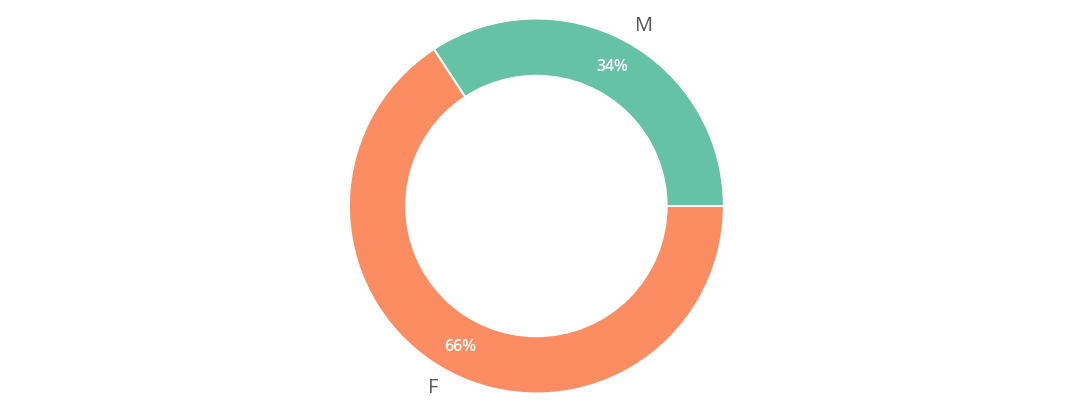

In [13]:
toolbox.plot_donut(X_sample, 'CODE_GENDER','', (15, 6))

In [6]:
t = X_sample.loc[[215797]]

In [12]:
t['AMT_CREDIT'].values[0]

1350000.0

In [12]:
print("X shape: {}, Y shape: {}".format(X.shape, y.shape))

X shape: (153753, 458), Y shape: (153753, 1)


In [27]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8, stratify=y)

CPU times: total: 3 s
Wall time: 4.93 s


In [9]:
print("x_train shape: {}, x_test shape: {}".format(X_train.shape, X_test.shape))

x_train shape: (107627, 458), x_test shape: (46126, 458)


In [28]:
del X, y
gc.collect()

602

'stratify' a bien fonctionner

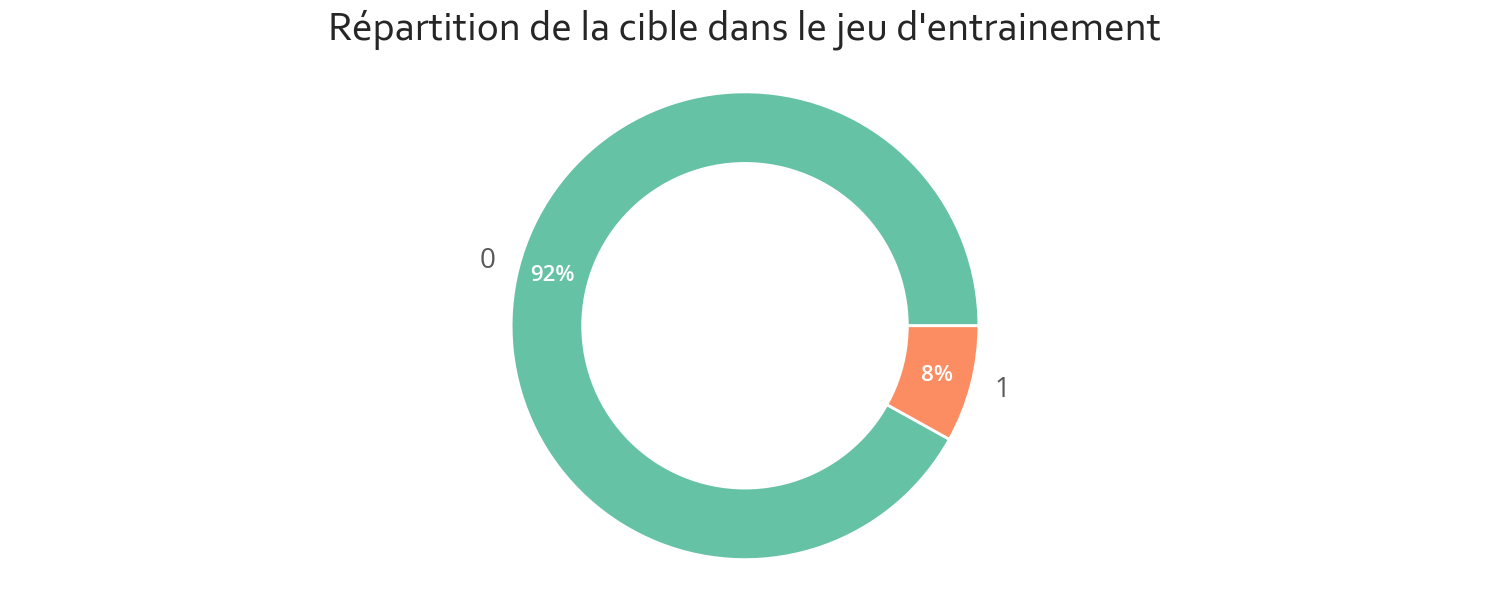

In [22]:
toolbox.plot_donut(y_train, 'TARGET','Répartition de la cible dans le jeu d\'entrainement', (15, 6))

In [38]:
preprocessed_data_missing_df = toolbox.missing_values_by_column(X_train)
preprocessed_data_missing_df.loc[preprocessed_data_missing_df['Missing Values (%)'] > 0]

,VARIABLES,Number of Missing Values,Missing Values (%)
8,AMT_GOODS_PRICE,111,0.10
40,EXT_SOURCE_2,238,0.22
92,DEF_60_CNT_SOCIAL_CIRCLE,342,0.32
91,OBS_60_CNT_SOCIAL_CIRCLE,342,0.32
90,DEF_30_CNT_SOCIAL_CIRCLE,342,0.32
...,...,...,...
301,REFUSED_AMT_DOWN_PAYMENT_MEAN,91719,85.22
300,REFUSED_AMT_DOWN_PAYMENT_MAX,91719,85.22
299,REFUSED_AMT_DOWN_PAYMENT_MIN,91719,85.22
308,REFUSED_RATE_DOWN_PAYMENT_MIN,91719,85.22


<h4 style="font-family:Corbel Light; color:#737373">Test transformations variables catégorielles</h4>

In [8]:
binary_col = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

encoder = OrdinalEncoder(dtype=int)
transformed_data = encoder.fit_transform(X_train[binary_col])
transformed_data_df = pd.DataFrame(transformed_data, columns=binary_col)
print(transformed_data_df.apply(lambda col : col.unique()))

   CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY
0            0             0                1
1            1             1                0


Le OneHotEncoder ajoute une colonne par modalité

In [6]:
categ_col = ['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE']
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
transformed_data = one_hot_encoder.fit_transform(X_train[categ_col])

In [7]:
pd.DataFrame(transformed_data.toarray(), columns=one_hot_encoder.get_feature_names_out()).head()

,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Problème : OneHotEncoder de sklearn met beaucoup trop de temps à encoder les 35 variables catégorielles de notre jeu de données (toujours pas fini au bout de 20 min)

Donc on va utiliser get_dummies de pandas, qui est bien plus rapide (1 min)

In [169]:
len(features_categ)

35

Testons notre nouvelle fonction:

In [139]:
df_train = pd.DataFrame(data=['cat', 'cat', 'dog', 'cat', 'parrot', 'dog', 'parrot'], columns=['Type'])
df_test = pd.DataFrame(data=['cat', 'parrot', 'cat', 'cat', 'dog', 'dog', 'parrot', 'rat'], columns=['Type'])

df_train['Color'] = ['grey', 'blue', 'green', 'red', 'green', 'grey', np.nan]
df_test['Color'] = ['grey', 'yellow', 'green', 'yellow', np.nan, 'pink', 'red', 'pink']

In [165]:
dummies = GetDummiesTransformer()

In [166]:
dummies.fit_transform(df_train)

,Type_cat,Type_dog,Type_parrot,Color_blue,Color_green,Color_grey,Color_red
0,1,0,0,0,0,1,0
1,1,0,0,1,0,0,0
2,0,1,0,0,1,0,0
3,1,0,0,0,0,0,1
4,0,0,1,0,1,0,0
5,0,1,0,0,0,1,0
6,0,0,1,0,0,0,0


In [147]:
dummies.transform(df_test)

,Type_cat,Type_dog,Type_parrot,Color_blue,Color_green,Color_grey,Color_red
0,1,0,0,0,0,1,0
1,0,0,1,0,0,0,0
2,1,0,0,0,1,0,0
3,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0
5,0,1,0,0,0,0,0
6,0,0,1,0,0,0,1
7,0,0,0,0,0,0,0


In [148]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

In [159]:
transformed_data = one_hot_encoder.fit_transform(df_train)
o = pd.DataFrame(transformed_data.toarray(), columns=one_hot_encoder.get_feature_names_out()).head()
o

,Type_cat,Type_dog,Type_parrot,Color_blue,Color_green,Color_grey,Color_red,Color_nan
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [168]:
transformed_data = one_hot_encoder.transform(df_test)
o = pd.DataFrame(transformed_data.toarray(), columns=one_hot_encoder.get_feature_names_out())
o

,Type_cat,Type_dog,Type_parrot,Color_blue,Color_green,Color_grey,Color_red,Color_nan
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Appliquons là à l'ensemble du jeu d'entrainement : on obtient un jeu de données final avec 731 variables

In [89]:
%%time
dummies = GetDummiesTransformer(features_categ)
transformed_data = dummies.fit_transform(X_train)

CPU times: total: 15.4 s
Wall time: 48.1 s


In [91]:
transformed_data.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,POS_NAME_CONTRACT_STATUS_MODE_Amortized debt,POS_NAME_CONTRACT_STATUS_MODE_Approved,POS_NAME_CONTRACT_STATUS_MODE_Completed,POS_NAME_CONTRACT_STATUS_MODE_Demand,POS_NAME_CONTRACT_STATUS_MODE_Returned to the store,POS_NAME_CONTRACT_STATUS_MODE_Signed,CC_NAME_CONTRACT_STATUS_MODE_Active,CC_NAME_CONTRACT_STATUS_MODE_Completed,CC_NAME_CONTRACT_STATUS_MODE_Demand,CC_NAME_CONTRACT_STATUS_MODE_Signed
191512,322062,F,N,Y,0,148500.0,251280.0,13761.0,180000.0,0.009630,...,0,0,0,0,0,0,0,0,0,0
173232,300747,F,N,Y,1,202500.0,497520.0,32521.5,450000.0,0.002042,...,0,0,0,0,0,0,0,0,0,0
147365,270865,M,Y,N,2,135000.0,463500.0,12874.5,463500.0,0.018634,...,0,0,0,0,0,0,1,0,0,0
185057,314515,F,Y,Y,0,157500.0,675000.0,24376.5,675000.0,0.018209,...,0,0,0,0,0,0,0,0,0,0
61950,171850,F,N,Y,0,157500.0,670500.0,37570.5,670500.0,0.015221,...,0,0,0,0,0,0,0,0,0,0


In [16]:
binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
features_categ = [col for col in X_train.columns if X_train[col].dtype == 'object' and col not in binary_features]

transformers_features = [{'feature': binary_features, 'estimator': [OrdinalEncoder(dtype=int)]}, 
                         {'feature': features_categ, 'estimator': [GetDummiesTransformer()]} 
                        ]

In [17]:
preprocessor = make_preprocessor(transformers_features)

In [18]:
transformed_data = preprocessor.fit_transform(X_train)

[ColumnTransformer] .... (1 of 3) Processing pipeline-1, total=   0.4s
[ColumnTransformer] .... (2 of 3) Processing pipeline-2, total=   5.4s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


In [19]:
features_getdummies = preprocessor.named_transformers_['pipeline-2'][0].get_feature_names()
features_final = [*binary_features, *features_getdummies]
features_final.extend([col for col in X_train.columns.values if col not in [*features_categ, *binary_features]])
len(features_final)

730

In [20]:
transformed_data_df = pd.DataFrame(transformed_data, columns=features_final)
transformed_data_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.044444,4.0,0.042946,0.0,1.0,0.044444,4.0,0.042946,90.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
describe_df = transformed_data_df.describe()

Problème : valeurs infinies

In [22]:
describe_df.loc['max'].sort_values()

DAYS_BIRTH                         -7.489000e+03
CLOSED_DAYS_CREDIT_MIN             -1.000000e+01
CLOSED_DAYS_CREDIT_MEAN            -1.000000e+01
INSTAL_DAYS_ENTRY_PAYMENT_MEAN     -6.000000e+00
CLOSED_DAYS_CREDIT_MAX             -3.000000e+00
                                        ...     
CC_AMT_CREDIT_LIMIT_ACTUAL_VAR      4.639091e+11
CC_AMT_DRAWINGS_CURRENT_VAR         6.075000e+11
CC_AMT_DRAWINGS_ATM_CURRENT_VAR     6.075000e+11
CC_AMT_PAYMENT_TOTAL_CURRENT_VAR    9.639054e+11
CC_AMT_PAYMENT_CURRENT_VAR          9.697328e+11
Name: max, Length: 730, dtype: float64

<h4 style="font-family:Corbel Light; color:#737373">Test transformations variables numériques</h4>

In [23]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [24]:
%%time
transformed_data = imputer.fit_transform(transformed_data)

CPU times: total: 59.2 s
Wall time: 16min 2s


<h4 style="font-family:Corbel Light; color:#737373">Test pipeline</h4>

In [14]:
binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
features_categ = [col for col in X_train.columns if X_train[col].dtype == 'object' and col not in binary_features]

transformers_features = [{'feature': binary_features, 'estimator': [OrdinalEncoder(dtype=int)]}, 
                         #{'feature': features_categ, 'estimator': [OneHotEncoder(handle_unknown='ignore')]} 
                         {'feature': features_categ, 'estimator': [GetDummiesTransformer()]} 
                        ]

transformers_dataset = [RandomUnderSampler(random_state=8, replacement=True)]

In [15]:
preprocessor = make_preprocessor(transformers_features)

In [99]:
pipeline = imb_make_pipeline(preprocessor, *transformers_dataset, DummyClassifier(strategy='most_frequent'), verbose=True)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(dtype=<class 'int'>))]),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('getdummiestransformer',
                                                                   <__main__.GetDummiesTransformer object at 0x000001D20BA2D0A0>)]),
                                                  ['NA...
                                                   'PREV_CODE_REJECT_REASON_MODE',
                                                   'PREV_NAME_TYPE_SUITE_MODE',
                                                   'PREV_NAME_CLIENT_TYPE_MODE',
                                                   'PREV_NAME_GOODS_CATEGORY_MODE',
                                                   'PREV_NAME_PORTFOLIO_MODE',
                                                   'PREV_NAME_PRODUCT_TYPE_MODE',
                                                   'PREV_CHANNEL_TYPE_MODE', ...])],
                                   verbose=True)),
                ('randomundersampler',
                 RandomUnderSampler(random_state=8, replacement=True)),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))],
         verbose=True)

In [100]:
pipeline.fit(X_train, y_train)

[ColumnTransformer] .... (1 of 3) Processing pipeline-1, total=   0.9s
[ColumnTransformer] .... (2 of 3) Processing pipeline-2, total=   6.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[Pipeline] . (step 1 of 3) Processing columntransformer, total=12.7min
[Pipeline]  (step 2 of 3) Processing randomundersampler, total= 1.7min
[Pipeline] ... (step 3 of 3) Processing dummyclassifier, total=   2.5s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(dtype=<class 'int'>))]),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('getdummiestransformer',
                                                                   <__main__.GetDummiesTransformer object at 0x000001D20BA2D0A0>)]),
                                                  ['NA...
                                                   'PREV_CODE_REJECT_REASON_MODE',
                                                   'PREV_NAME_TYPE_SUITE_MODE',
                                                   'PREV_NAME_CLIENT_TYPE_MODE',
                                                   'PREV_NAME_GOODS_CATEGORY_MODE',
                                                   'PREV_NAME_PORTFOLIO_MODE',
                                                   'PREV_NAME_PRODUCT_TYPE_MODE',
                                                   'PREV_CHANNEL_TYPE_MODE', ...])],
                                   verbose=True)),
                ('randomundersampler',
                 RandomUnderSampler(random_state=8, replacement=True)),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))],
         verbose=True)

In [101]:
transformed_data = pipeline[0].transform(X_train)

On retrouve les 730 variables (comme précédemment)

In [102]:
transformed_data.shape

(215254, 730)

In [103]:
features_getdummies = pipeline[0].named_transformers_['pipeline-2'][0].get_feature_names()
X_train.columns.values.shape[0] - len(features_categ) + len(features_getdummies) 

730

In [104]:
features_final = [*binary_features, *features_getdummies]
features_final.extend([col for col in X_train.columns.values if col not in [*features_categ, *binary_features]])
len(features_final)

730

In [105]:
transformed_data_df = pd.DataFrame(transformed_data, columns=features_final)
transformed_data_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.044444,4.0,0.042946,0.0,1.0,0.044444,4.0,0.042946,90.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vérifions pour quelques colonnes numériques, non transformées au hasard que les valeurs correspondent

In [106]:
transformed_data_df[['AMT_INCOME_TOTAL']].head()

,AMT_INCOME_TOTAL
0,148500.0
1,202500.0
2,135000.0
3,157500.0
4,157500.0


In [110]:
X_train.shape

(215254, 458)

In [107]:
X_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
322062,Cash loans,F,N,Y,0,148500.0,251280.0,13761.0,180000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300747,Cash loans,F,N,Y,1,202500.0,497520.0,32521.5,450000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270865,Cash loans,M,Y,N,2,135000.0,463500.0,12874.5,463500.0,Unaccompanied,...,1.0,0.044444,4.0,0.042946,0.0,1.0,0.044444,4.0,0.042946,90.0
314515,Cash loans,F,Y,Y,0,157500.0,675000.0,24376.5,675000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171850,Cash loans,F,N,Y,0,157500.0,670500.0,37570.5,670500.0,Family,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
resampled_data = pipeline[:-1].fit_resample(X_train, y_train)

[ColumnTransformer] .... (1 of 3) Processing pipeline-1, total=   0.5s
[ColumnTransformer] .... (2 of 3) Processing pipeline-2, total=   5.3s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total= 6.9min
[Pipeline]  (step 2 of 2) Processing randomundersampler, total=  59.2s


In [119]:
resampled_data[0].shape

(34754, 730)

<h4 style="font-family:Corbel Light; color:#737373">Test transformations pour rééquilibrer le jeu d'entraînement</h4>

Rappel : notre jeu d'entrainement est fortement déséquilibré. Seuls 8% des demandes de prêts ayant été refusées (classe 1). Un modèle entraîné sur ce jeu déséquilibré risque d'ignorer complètement la classe 1 et donc d'être très mauvais pour identifier les demandes de crédit qu'il vaudrait mieux refuser. Or, ce sont ces demandes que l'on cherche précisémment à identifier.

2 types de stratégies :
- Ajouter des individus de la classe 1 (Over Sampling)
- Supprimer des individus de la classe 0 (Under Sampling) -> perte d'informations

Nous allons tester ces techniques sur un échantillon du jeu d'entrainement pour ne pas utiliser toute la RAM.

In [31]:
X_train_sample, y_train_sample = resample(X_train, y_train, n_samples = 1_000, stratify=y_train)

In [32]:
X_train_sample.shape

(1000, 458)

In [33]:
binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
features_categ = [col for col in X_train.columns if X_train[col].dtype == 'object' and col not in binary_features]
numeric_features = X_train._get_numeric_data().columns

transformers_features = [{'feature': binary_features,  'estimator': [OrdinalEncoder(dtype=int)]}, 
                         {'feature': features_categ,   'estimator': [GetDummiesTransformer()]},
                         {'feature': numeric_features, 'estimator' : [SimpleImputer(missing_values=np.nan, strategy='median')]}
                        ]

In [34]:
preprocessor = make_preprocessor(transformers_features)

In [35]:
X_train_sample_trans = preprocessor.fit_transform(X_train_sample)

Technique 1 : Random Under Sampling - Supprime au hasard des individus de la classe majoritaire (0)

In [46]:
rus = RandomUnderSampler(random_state=8)
x_rus, y_rus = rus.fit_resample(X_train_sample_trans, y_train_sample)

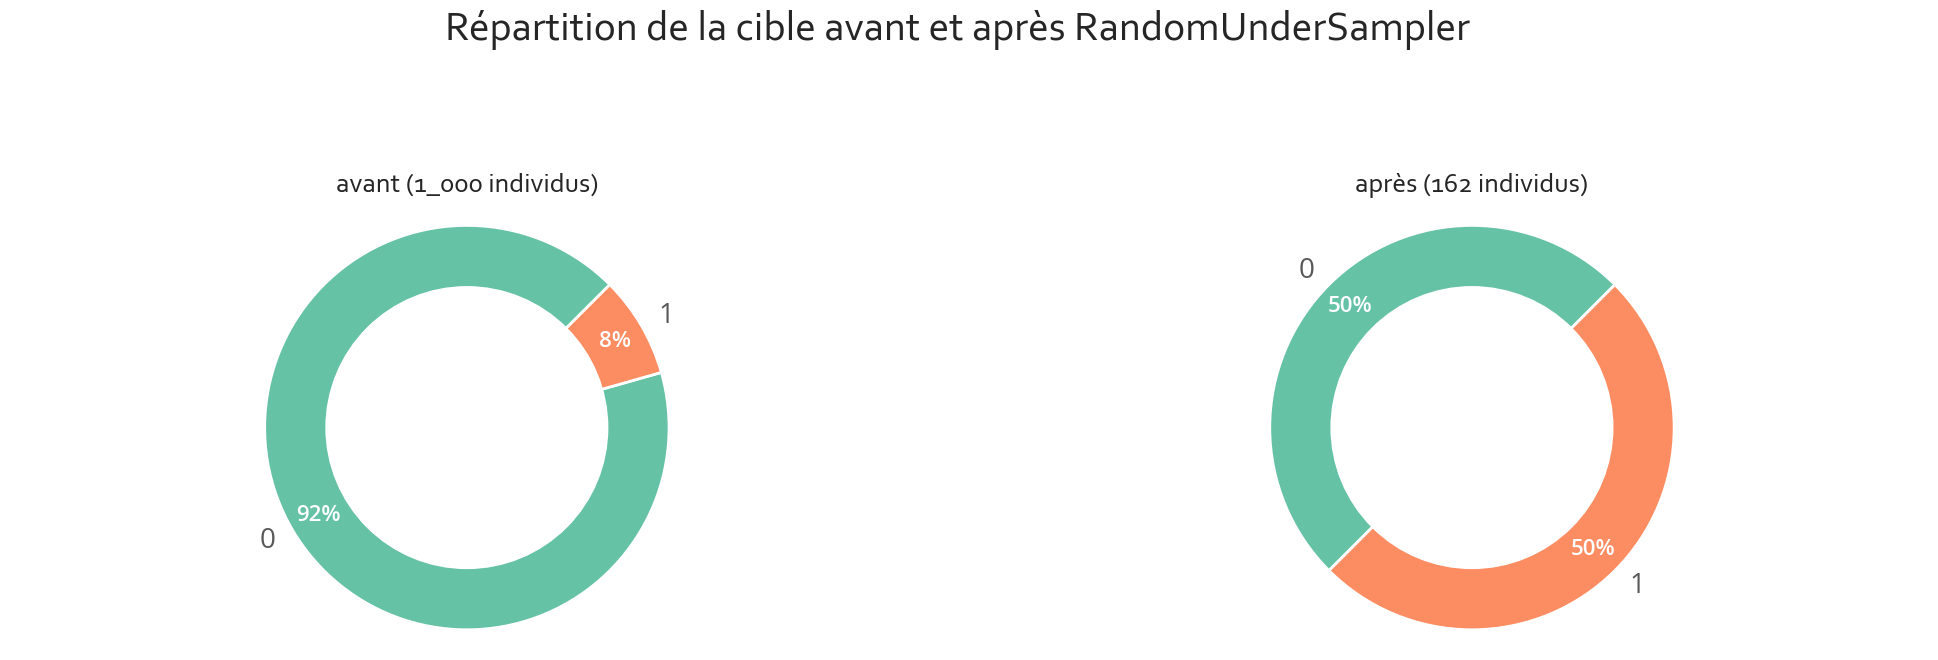

In [47]:
toolbox.compare_donuts(y_train_sample, y_rus, 'TARGET', 'Répartition de la cible avant et après RandomUnderSampler', (20, 7), top=0.7)

In [48]:
del rus, y_rus, x_rus
gc.collect()

6456

Technique 2 : Under Sampling Tomek Links - Supprime tout individu de la classe 0 qui est le plus proche voisin d'un individu de la classe 1.

Ne fonctionne pas sur un jeu de données contenant des nan

In [49]:
tl = TomekLinks(sampling_strategy='majority')
x_tl, y_tl = tl.fit_resample(X_train_sample_trans, y_train_sample)

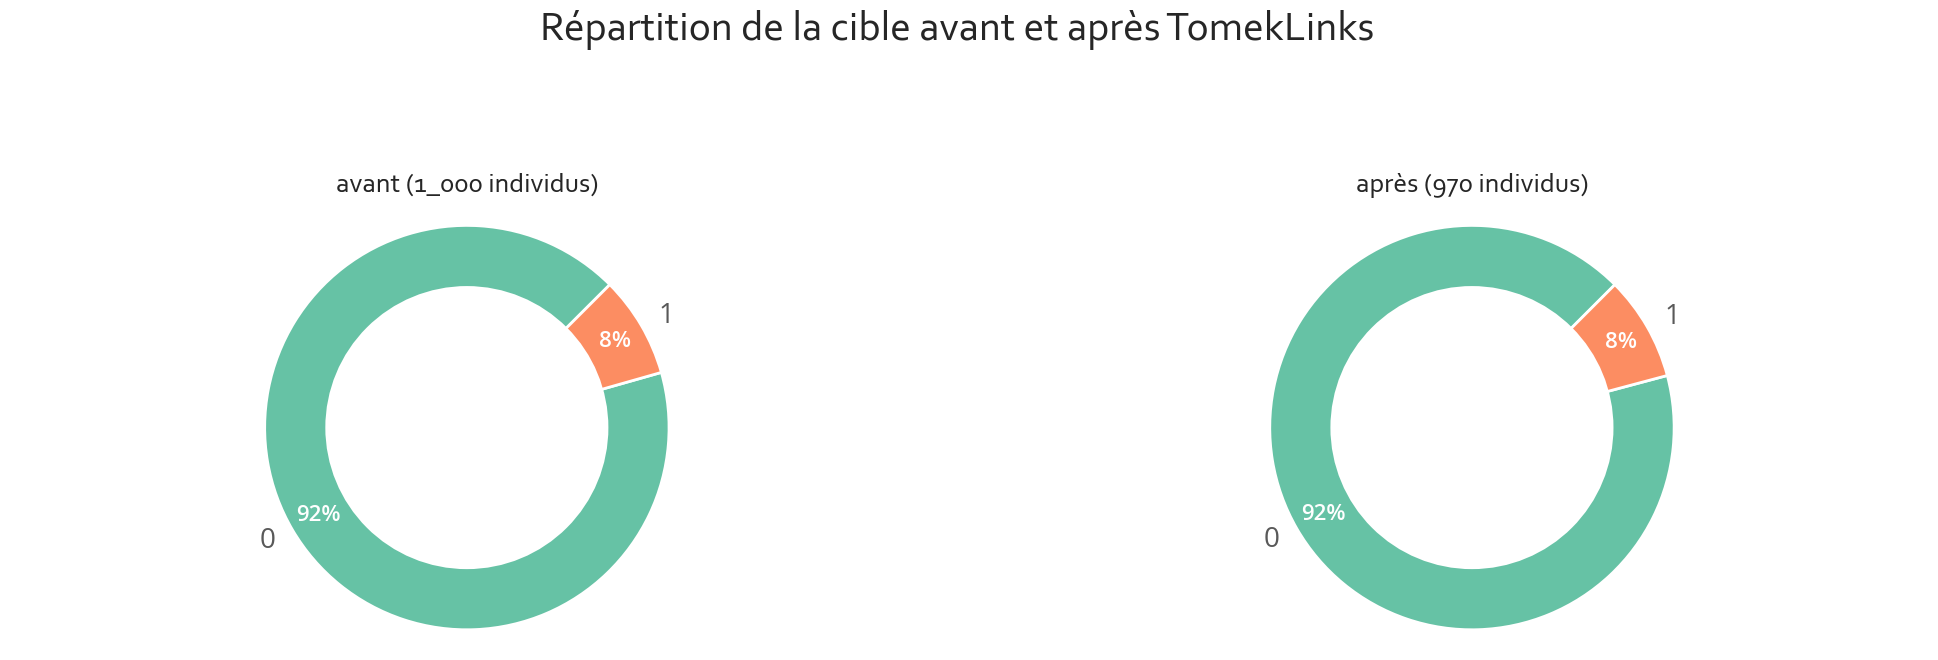

In [51]:
toolbox.compare_donuts(y_train_sample, y_tl, 'TARGET', 'Répartition de la cible avant et après TomekLinks', (20, 7), top=0.7)

In [55]:
del tl, y_tl, x_tl
gc.collect()

7605

Technique 3 : Random Over Sampling - tire des individus de la classe 1 au hasard, avec remise pour les ajouter au jeu de données, jusqu'à ce qu'on ait le même nombre d'individus dans les 2 classes.

Problème : mon ordinateur ne supporte pas de travailler sur un jeu de données aussi gros. Cette technique le fait crasher.

In [56]:
ros = RandomOverSampler(random_state=8)
x_ros, y_ros = ros.fit_resample(X_train_sample_trans, y_train_sample)

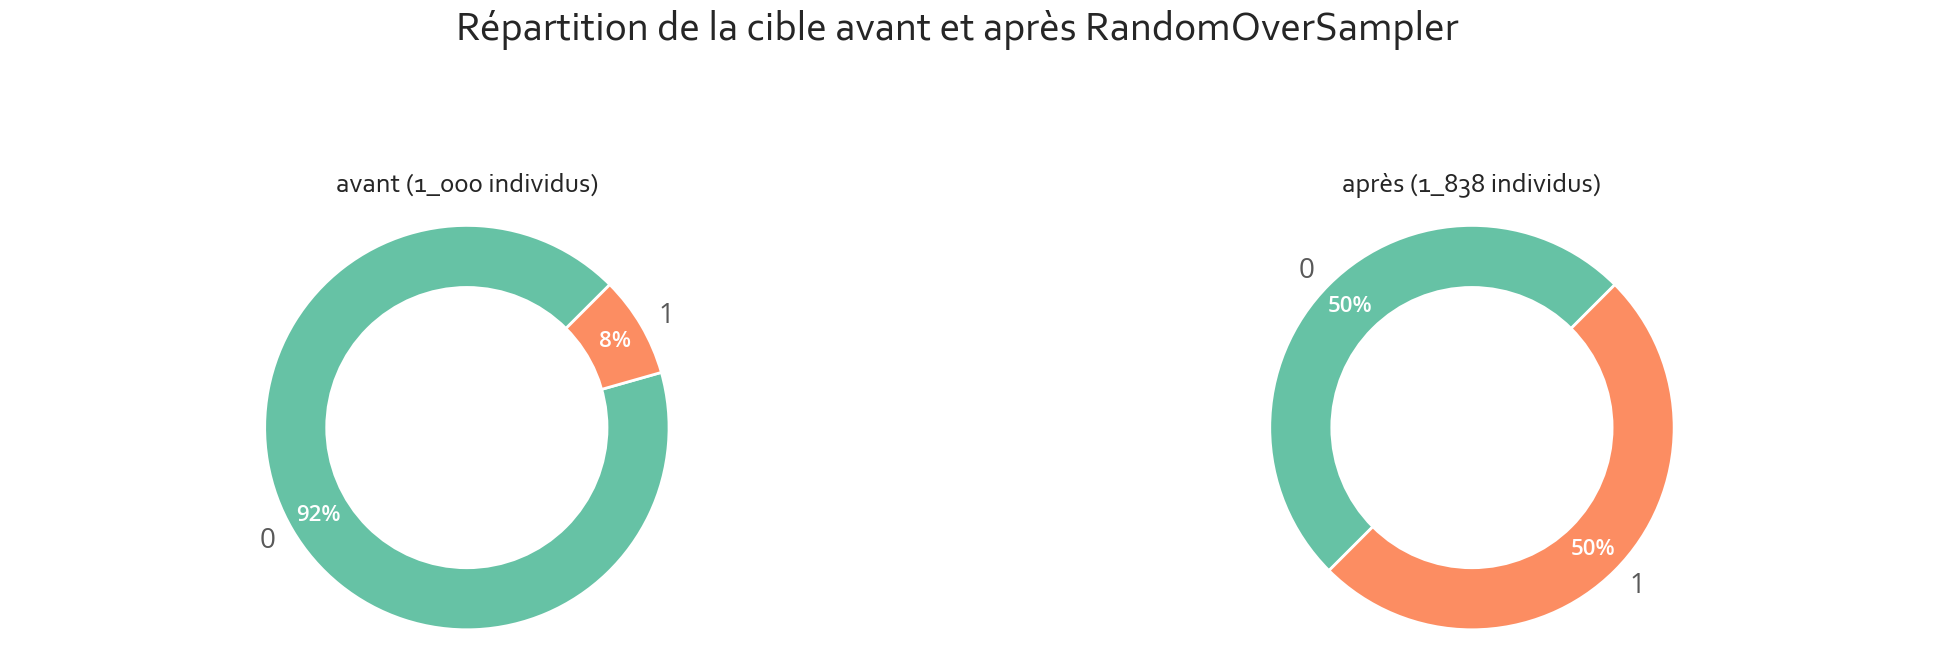

In [57]:
toolbox.compare_donuts(y_train_sample, y_ros , 'TARGET', 'Répartition de la cible avant et après RandomOverSampler', (20, 7), top=0.7)

In [58]:
del ros, y_ros, x_ros
gc.collect()

6197

Technique 4 : SMOTE (Synthetic Minority Oversampling Technique)

L'algorithme :
- tire un individu de la classe minoritaire au hasard
- calcule ses k plus proches voisins 
- tire un des plus proches voisins au hasard
- relie ces deux points par une droite et choisi un point de cette droite au hasard comme nouvel individu.

Problème : SMOTE ne fonctionne pas sur jeu de données car il contient des nan

In [60]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X_train_sample_trans, y_train_sample)

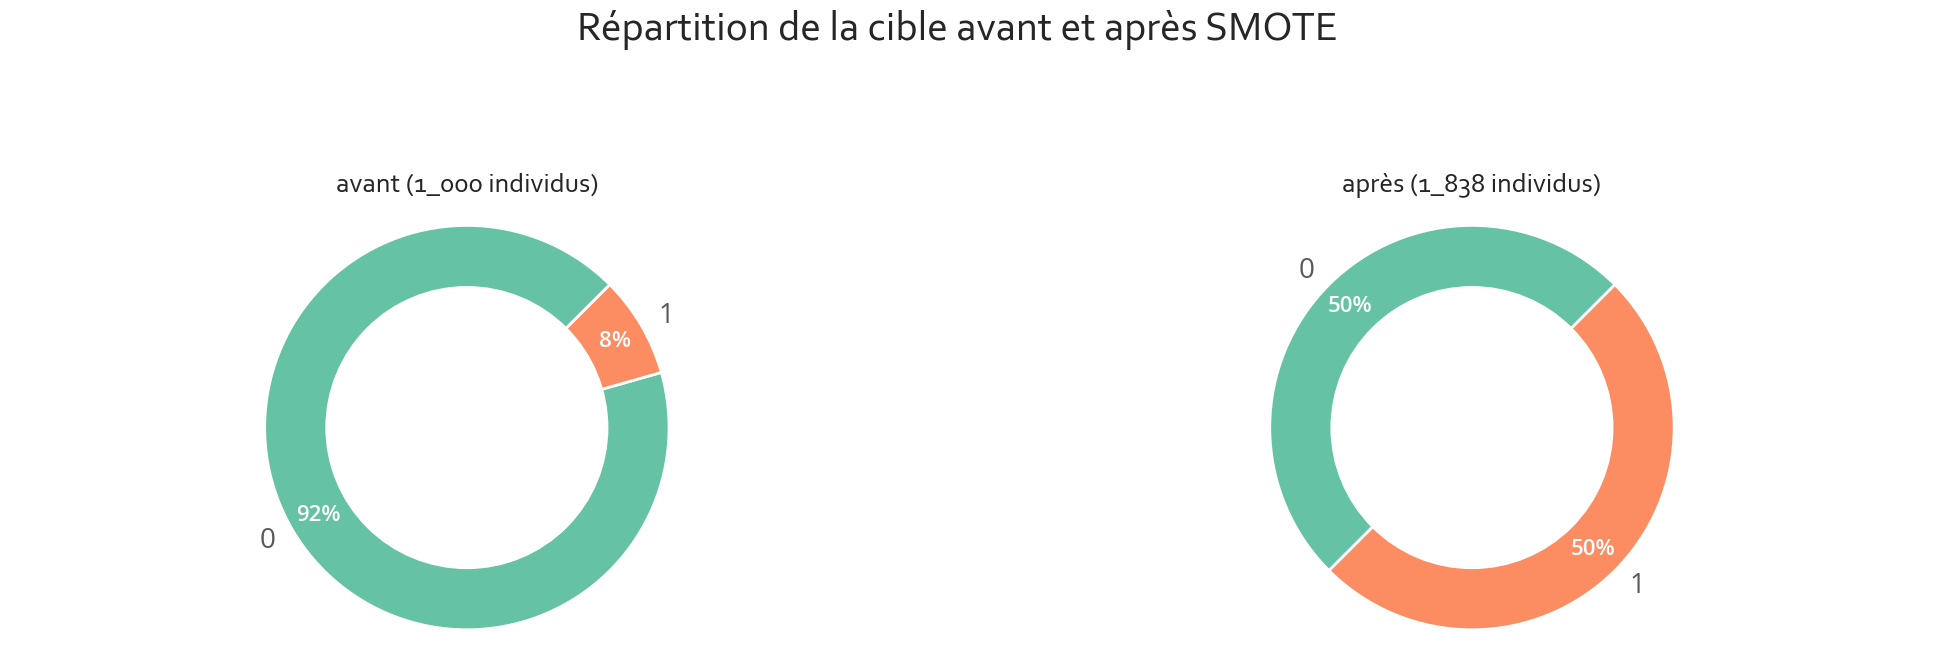

In [62]:
toolbox.compare_donuts(y_train_sample, y_smote , 'TARGET', 'Répartition de la cible avant et après SMOTE', (20, 7), top=0.7)

In [64]:
del smote, y_smote, x_smote
gc.collect()

12453

Technique 5 : NearMiss - Undersampling - 

Ne marche pas sur un jeu de données contenant des nans

In [63]:
nm = NearMiss()
x_nm, y_nm = nm.fit_resample(X_train_sample_trans, y_train_sample)

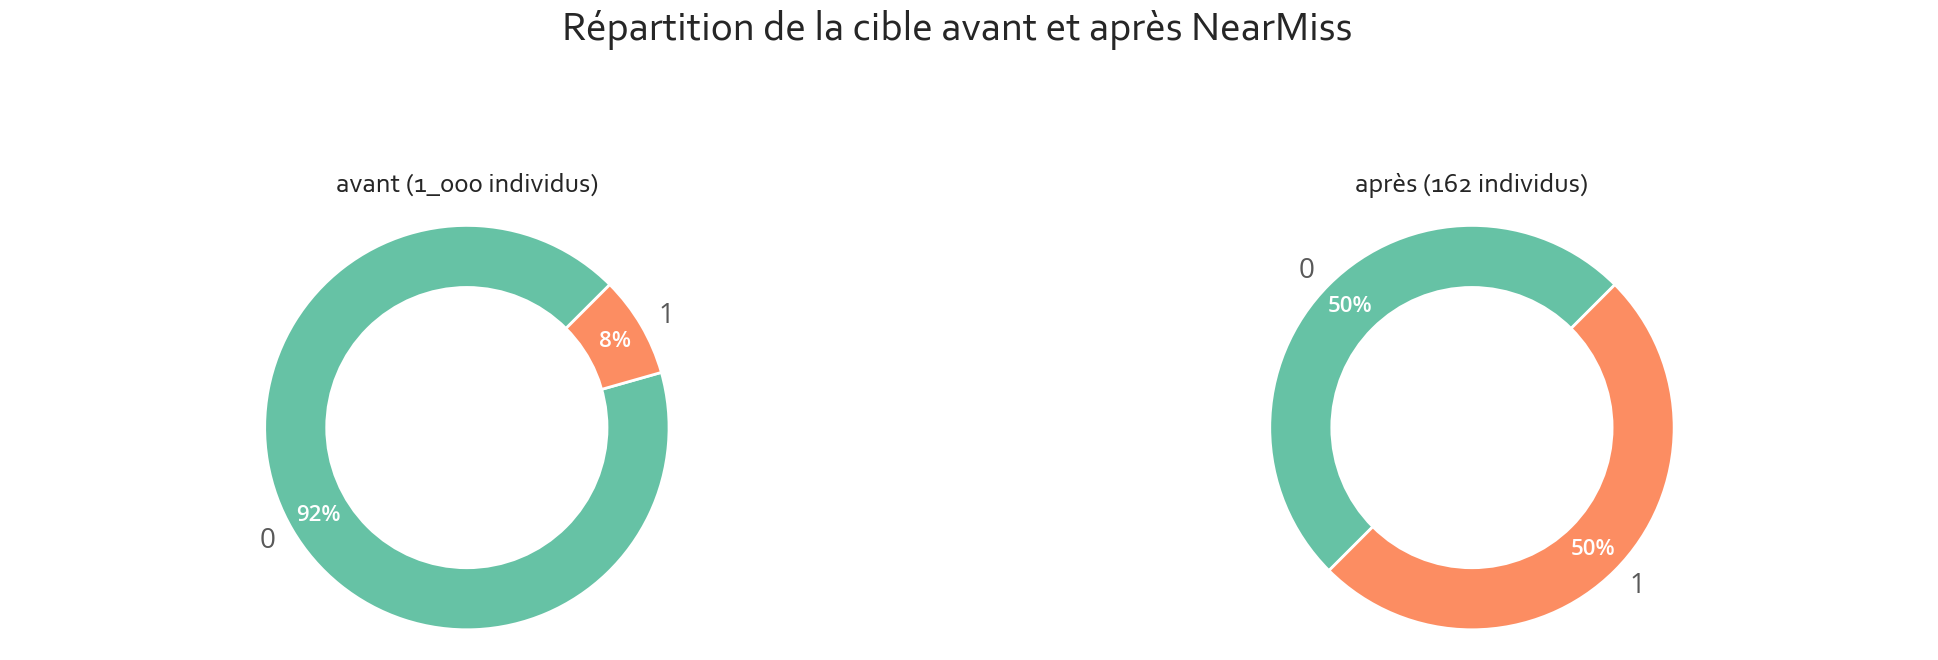

In [67]:
toolbox.compare_donuts(y_train_sample, y_nm , 'TARGET', 'Répartition de la cible avant et après NearMiss', (20, 7), top=0.7)

In [68]:
del nm, y_nm, x_nm
gc.collect()

12418

Technique 6 - Utiliser l'hyperparamètre 'class_weight' pour pondérer chaque individu selon la classe à laquelle il appartient lors du scoring.

Si class_weight = 'balanced': poids classe j = nombre d'observations / (nb de classes * nb d'individus dans la classe j)

In [72]:
class_weight.compute_class_weight('balanced', classes=np.unique(y_train_sample), y=y_train_sample['TARGET'])

array([0.54406964, 6.17283951])

Technique 7 - combiner oversampling et undersampling

Applique RandomUnderSampling pour réduire le nombre d'individus dans la classe majoritaire, et SMOTE pour ajouter des individus dans la classe minoritaire.

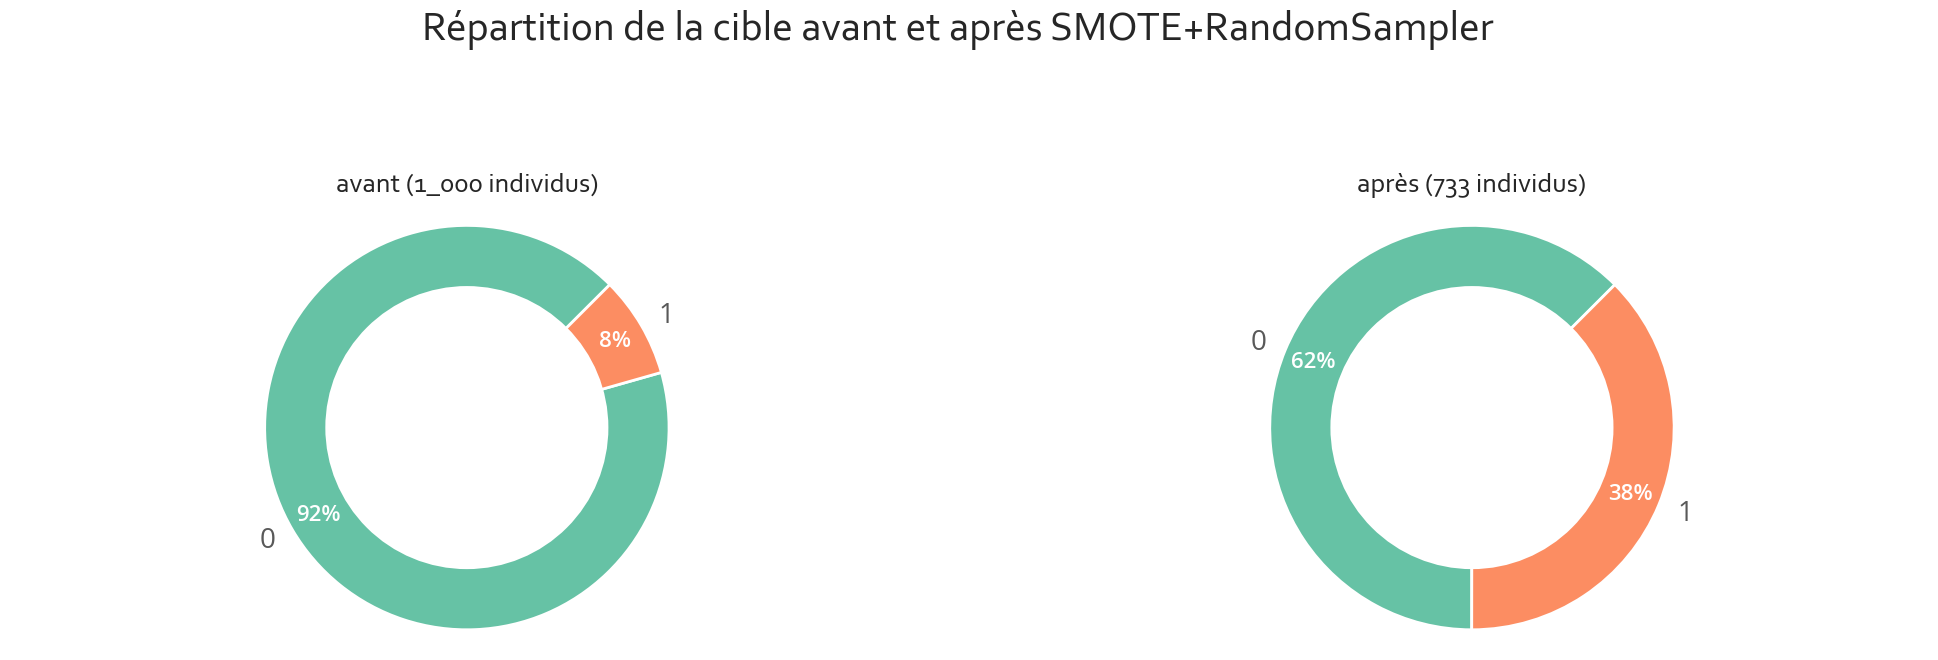

In [58]:
pipeline = imb_make_pipeline(SMOTE(random_state=8, sampling_strategy=0.3), RandomUnderSampler(random_state=8, sampling_strategy=0.6))

x_rus_smote, y_rus_smote = pipeline.fit_resample(X_train_sample_trans, y_train_sample)
toolbox.compare_donuts(y_train_sample, y_rus_smote , 'TARGET', 'Répartition de la cible avant et après SMOTE+RandomSampler', (20, 7), top=0.7)

<h4 style="font-family:Corbel Light; color:#737373">Score métier</h4>

In [15]:
def cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1], normalize='all').ravel()
    total_cost = (10*fn + fp)/10
    
    return total_cost

In [16]:
def custom_cost_score(y_true, y_pred_positive_proba, return_thresh=False):
    scores = []
    thresholds=np.arange(0, 1, 0.001)
    for thresh in thresholds:
        y_pred_labels = (y_pred_positive_proba >=thresh).astype('int')
        scores.append(cost(y_true, y_pred_labels))
        
    best_thresh_index = np.argmin(scores)

    if return_thresh:
        return scores[best_thresh_index], thresholds[best_thresh_index]
    
    return scores[best_thresh_index]

y_pred_proba = proba of the positive class (1-mauvais client)

for each threshold :
- convert proba to class labels using the threshold
- evaluate class labels
- if score is better than best score : adopt threshold
- use adopted threshold when making class predictions on new data

Vérifions que la fonction de coût métier fonctionne 

In [ ]:
y_pred_p = pipeline.predict_proba(X_test)
y_pred_p

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [126]:
y_pred = pipeline.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [127]:
confusion_matrix(y_test, y_pred, labels=[0,1])

array([[84805,     0],
       [ 7448,     0]], dtype=int64)

On a bien dans l'ordre : tn, fp, fn, tp

In [129]:
confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()

array([84805,     0,  7448,     0], dtype=int64)

In [130]:
confusion_matrix(y_test, y_pred, labels=[0,1], normalize='all')

array([[0.9192655, 0.       ],
       [0.0807345, 0.       ]])

In [134]:
cost(y_test, y_pred)

0.08073450185901813

In [142]:
custom_cost_score(y_test, y_pred_p[:,1])

0.08073450185901813

<h4 style="font-family:Corbel Light; color:#737373">Test modèles</h4>

In [18]:
#check the current tracking directory
mlflow.tracking.get_tracking_uri()

'file:///C:/Users/Hermine/Documents/PoleEmploi/OpenClassRooms/FormationDataScientist/Projet%207/Notebook/mlruns'

In [14]:
def grid_search_cv_and_score(classifiers: [dict], X: pd.DataFrame, y: pd.DataFrame, 
                             X_test: pd.DataFrame, y_test: pd.DataFrame,
                             transformers_features: [dict], 
                             transformers_dataset=[], n_splits=5): 
    
    scores_cv_all = pd.DataFrame()
    scores_test = []
    preprocessor = make_preprocessor(transformers_features)
    
    for model in classifiers: 
        classifier = imb_make_pipeline(preprocessor, *transformers_dataset, model['classifier']) #verbose=True
        
        scorers = build_scorers()
        
        grid = GridSearchCV(estimator=classifier, 
                            param_grid=model['params'], 
                            scoring=scorers, 
                            cv=StratifiedKFold(n_splits), 
                            return_train_score=True, 
                            refit='custom_score',
                            verbose=1)
        
        with mlflow.start_run():
            grid.fit(X, y)
            
            # Log parameter, metrics, and model to MLflow
            best_model_index = grid.best_index_
            mlflow.log_metric("mean_time_fit", grid.cv_results_['mean_fit_time'][best_model_index])
            mlflow.log_metric("std_time_fit", grid.cv_results_['std_fit_time'][best_model_index])
            
            for param, best_value in grid.best_params_.items():
                    mlflow.log_param(param, best_value)
            
            for set_name in ['test', 'train']:
                for score in scorers.keys():
                    mlflow.log_metric("mean_{}_cv_{}".format(score, set_name), 
                                      grid.cv_results_['mean_{}_{}'.format(set_name, score)][best_model_index])
                    mlflow.log_metric("std_{}_cv_{}".format(score, set_name), 
                                      grid.cv_results_['std_{}_{}'.format(set_name, score)][best_model_index])
            
            y_pred = grid.predict_proba(X)
            score, thresh = custom_cost_score(y, y_pred[:,1], return_thresh=True)
            y_pred_test = grid.predict_proba(X_test)
            y_pred_test = (y_pred_test[:,1]>=thresh).astype('int')
            
            mlflow.log_param("threshold", thresh)
            mlflow.log_metric("custom_score_test", cost(y_test, y_pred_test))
            mlflow.log_metric("accuracy_test", accuracy_score(y_test, y_pred_test))
            mlflow.log_metric("balanced_accuracy", balanced_accuracy_score(y_test, y_pred_test)) #_test
            mlflow.log_metric("roc_auc_test", roc_auc_score(y_test, y_pred_test))
            mlflow.sklearn.log_model(grid, "model")
            
        scores_cv = build_score_df_from_grid(grid, model['name'], ['test', 'train'], scorers.keys())
        scores_test.append(score_test(grid, y_pred_test, y_test, model['name'], thresh))
        
        scores_cv_all = pd.concat([scores_cv_all, scores_cv], ignore_index=True)
      
    scores_test_all = pd.DataFrame(scores_test)
    mlflow.end_run() 
    
    return scores_cv_all, scores_test_all

In [39]:
binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
categ_features = [col for col in X_train.columns if X_train[col].dtype == 'object' and col not in binary_features]
numeric_features = X_train._get_numeric_data().columns

In [18]:
transformers_features = [{'feature': binary_features, 'estimator': [OrdinalEncoder(dtype=int)]}, 
                         {'feature': categ_features, 'estimator': [GetDummiesTransformer()]},
                         {'feature': numeric_features, 'estimator': [SimpleImputer(missing_values=np.nan, strategy='median'), RobustScaler()]}
                        ]
#SMOTE(random_state=8, sampling_strategy=0.3), , sampling_strategy=0.6
sampler = [RandomUnderSampler(random_state=8)]

<h5 style="font-family:Corbel Light; color:#737373">Modèles Linéaires + Base</h5>

In [76]:
classifiers_base = [
              {'name': 'dummy', 
               'classifier': DummyClassifier(), 
               'params': {'dummyclassifier__strategy':(['most_frequent'])}
              },
              {'name': 'logistic_reg', 
               'classifier': LogisticRegression(), 
               'params' : {'logisticregression__C': ([0.01, 0.1, 1, 10, 100]), 
                           'logisticregression__solver' : (['sag', 'saga'])}
              }
            ]

In [78]:
%%time
scores_cv_base, scores_test_base = grid_search_cv_and_score(classifiers_base, 
                                                            X_train, y_train.values.ravel(), 
                                                            X_test, y_test.values.ravel(),
                                                            transformers_features, 
                                                            sampler, n_splits=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Hermine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hermine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hermine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hermine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hermine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hermine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

CPU times: total: 51min 34s
Wall time: 1h 1min 26s


Svm prend trop de temps a être entrainé.

<h5 style="font-family:Corbel Light; color:#737373">Modèles Ensemblistes</h5>

In [91]:
classifiers_ensemble = [
                          {'name': 'bagging', 
                           'classifier': BaggingClassifier(random_state=8), 
                           'params' : {'baggingclassifier__n_estimators': ([10, 50, 100]),
                                       #'baggingclassifier__max_features': ([1, 0.5, 0.8]),
                                       #'baggingclassifier__bootstrap': ([True, False]), 
                                       #'baggingclassifier__bootstrap_features': ([True, False])
                                      }
                          },
                         {'name': 'random_forest', 
                          'classifier': RandomForestClassifier(random_state=8), 
                          'params' : {'randomforestclassifier__n_estimators': ([100, 300]),
                                     #'randomforestclassifier__max_depth': ([2, 5, 10]), 
                                     'randomforestclassifier__max_features': ([None, 'sqrt', 'log2']),
                                     #'randomforestclassifier__class_weight': (['balanced', None]),
                                     }
                          }, 
                        {'name': 'adaboost', 
                         'classifier': AdaBoostClassifier(random_state=8), 
                         'params' : {'adaboostclassifier__n_estimators': ([50, 100]),
                                     'adaboostclassifier__learning_rate': ([0.1, 1]),
                                     'adaboostclassifier__algorithm': (['SAMME', 'SAMME.R']),
                                    }
                          },
                        {'name': 'gboost', 
                         'classifier': GradientBoostingClassifier(random_state=8), 
                         'params' : {'gradientboostingclassifier__n_estimators': ([100, 300]),
                                     'gradientboostingclassifier__max_depth': ([3, 6]),
                                     'gradientboostingclassifier__learning_rate': ([0.01, 0.1, 1]),
                                     #'gradientboostingclassifier__subsample': ([0.5, 0.7, 1]),
                                     #'gradientboostingclassifier__max_features': ([1, 0.5, 0.8]),
                                     #'gradientboostingclassifier__min_samples_leaf': ([2, 5]),
                                     #'gradientboostingclassifier__min_samples_split': ([2, 5]),
                                      }
                          }
            ]

In [38]:
classifiers_ensemble = [
                        {'name': 'gboost', 
                         'classifier': GradientBoostingClassifier(random_state=8), 
                         'params' : {'gradientboostingclassifier__n_estimators': ([300]), #, 300
                                       #'gradientboostingclassifier__max_depth': ([3, 6]),
                                       #'gradientboostingclassifier__learning_rate': ([0.01, 0.1, 1]),
                                       #'gradientboostingclassifier__subsample': ([0.5, 0.7, 1]),
                                       #'gradientboostingclassifier__max_features': ([1, 0.5, 0.8]),
                                       #'gradientboostingclassifier__min_samples_leaf': ([2, 5]),
                                       #'gradientboostingclassifier__min_samples_split': ([2, 5]),
                                      }
                          }
            ]

In [ ]:
%%time
scores_cv_ensemble, scores_test_ensemble = grid_search_cv_and_score(classifiers_ensemble, X_train, y_train.values.ravel(), 
                                                                    X_test, y_test.values.ravel(),
                                                                    transformers_features, 
                                                                    sampler, n_splits=3)

2023/06/07 16:26:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/07 16:26:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/06/07 16:26:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/07 16:26:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2023/06/07 16:27:06 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(dtype=<class 'int'>))]),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
          ...`


Fitting 3 folds for each of 1 candidates, totalling 3 fits



KeyboardInterrupt



In [ ]:
scores_cv = pd.concat([scores_cv_base, scores_cv_ensemble], ignore_index=True)
scores_test = pd.concat([scores_test_base, scores_test_ensemble], ignore_index=True)

scores_cv.to_pickle('Scores_cv.pkl')
scores_test.to_pickle('Scores_test.pkl')

<h5 style="font-family:Corbel Light; color:#737373">Modèles qui gèrent les valeurs manquantes</h5>

In [57]:
transformers_features_nan = [{'feature': binary_features, 'estimator': [OrdinalEncoder(dtype=int)]}, 
                             {'feature': categ_features, 'estimator': [GetDummiesTransformer()]},
                             {'feature': numeric_features, 'estimator': [RobustScaler()]}
                             ]

classifiers_handle_nan = [
                          {'name': 'xgboost', 
                           'classifier': XGBClassifier(seed=8), 
                           'params' : {'xgbclassifier__eta': ([0.01, 0.1, 1]),
                                       'xgbclassifier__max_depth': ([3, 6]),
                                       #'xgbclassifier__colsample_bytree': ([0.4, 1]),
                                       #'xgbclassifier__gamma': ([0, 0.1]),
                                       #'xgbclassifier__reg_lambda': ([1, 10, 50]),
                                       'xgbclassifier__n_estimators': ([100, 500, 1_000]),
                                       #'xgbclassifier__subsample': ([1, 0.5, 0.8]),
                                      }
                          },
                          {'name': 'lgbm', 
                           'classifier': LGBMClassifier(random_state=8), 
                           'params' : {'lgbmclassifier__learning_rate': ([0.01, 0.1, 1]),
                                       'lgbmclassifier__n_estimators': ([100, 500, 1_000]),
                                       'lgbmclassifier__max_depth': ([3, 6]),
                                       #'lgbmclassifier__num_leaves': ([34]),
                                       #'lgbmclassifier__colsample_bytree': ([.5, 0.8, 1]),
                                       #'lgbmclassifier__subsample': ([0.8, 0.2]),
                                       #'lgbmclassifier__reg_alpha': ([0.04, 0]),
                                       #'lgbmclassifier__min_split_gain': ([0.02]),
                                       #'lgbmclassifier__reg_lambda': ([0.07, 0]),
                                       #'lgbmclassifier__min_child_weight': ([39]),
                                      }
              }    
            ]

In [ ]:
%%time
scores_cv_handle_nan, scores_test_handle_nan = grid_search_cv_and_score(classifiers_handle_nan, X_train, y_train.values.ravel(), 
                                                                        X_test, y_test.values.ravel(),
                                                                        transformers_features_nan, 
                                                                        transformers_dataset, n_splits=3)

In [ ]:
set_config(transform_output="pandas")
cat_features=[*binary_features, *categ_features]
cat_features_pipeline = ['pipeline__' + feature for feature in cat_features]
transformers_features_cat = [{'feature': cat_features, 
                              'estimator': [SimpleImputer(missing_values=np.nan, fill_value="NaN", strategy='constant')]}]

catboost = [
              {'name': 'catboost', 
               'classifier': ctb.CatBoostClassifier(cat_features=cat_features_pipeline, random_seed=8), 
               'params' : {'catboostclassifier__learning_rate': ([0.01, 0.1, 1]),
                           'catboostclassifier__iterations': ([100, 500, 1_000]),
                           #'catboostclassifier__l2_leaf_reg': ([0.4, 1]),
                           #'catboostclassifier__subsample': ([1, 0.5, 0.8]),
                           'catboostclassifier__depth': ([3, 6]),
                           #'catboostclassifier__ignored_features': ([100, 500, 1_000]),
                           #'catboostclassifier__max_leaves': ([1, 0.5, 0.8]),
                           #'catboostclassifier__auto_class_weights': ([None, 'Balanced', 'SqrtBalanced']),
                          }
              }
            ]

In [ ]:
scores_cv_catboost, scores_test_catboost = grid_search_cv_and_score(catboost, X_train, y_train.values.ravel(), 
                                                                    X_test, y_test.values.ravel(),
                                                                    transformers_features_cat, 
                                                                    transformers_dataset, n_splits=3)

In [ ]:
scores_cv = pd.concat([scores_cv, scores_cv_catboost], ignore_index=True)
scores_test = pd.concat([scores_test, scores_test_catboost], ignore_index=True)

scores_cv.to_pickle('Scores_cv.pkl')
scores_test.to_pickle('Scores_test.pkl')

<h5 style="font-family:Corbel Light; color:#737373">Modèles ImbLearn</h5>

In [98]:
sklearn.utils.parallel.Parallel()

In [92]:
classifiers_brdnf = [
              {'name': 'balanced_random_forest', 
               'classifier': BalancedRandomForestClassifier(random_state=8), 
               'params' : {#'balancedrandomforestclassifier__class_weight': (['balanced', None, 'balanced_subsample']),
                           #'balancedrandomforestclassifier__n_estimators': ([100, 500, 1_000]),
                           #'balancedrandomforestclassifier__max_depth': ([2, 5, 10]), 
                           #'balancedrandomforestclassifier__max_features': ([None, 0.5, 0.8]),
                           'balancedrandomforestclassifier__n_estimators': ([100])
                          }
              }
            ]

In [93]:
classifiers_rusboost = [
              {'name': 'rusboost', 
               'classifier': RUSBoostClassifier(random_state=8), 
               'params' : {#'rusboostclassifier__n_estimators': ([10, 50, 100]),
                           #'rusboostclassifier__learning_rate': ([1.0, 0.5, 0.1]),
                           #'rusboostclassifier__algorithm': (['SAMME', 'SAMME.R']),
                           'rusboostclassifier__n_estimators': ([100])
                          }
              }
            ]

In [ ]:
%%time
scores_cv_rusboost, scores_test_rusboost = grid_search_cv_and_score(classifiers_rusboost, X_train, y_train.values.ravel(), 
                                                                    X_test, y_test.values.ravel(),
                                                                    transformers_features, 
                                                                    n_splits=3)

2023/06/07 20:23:57 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(dtype=<class 'int'>))]),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
          ...`


Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
scores_cv = pd.concat([scores_cv, scores_cv_rusboost], ignore_index=True)
scores_test = pd.concat([scores_test, scores_cv_rusboost], ignore_index=True)

scores_cv.to_pickle('Scores_cv.pkl')
scores_test.to_pickle('Scores_test.pkl')

<h5 style="font-family:Corbel Light; color:#737373">Résultats</h5>

In [39]:
scores_cv = pd.read_pickle('Scores_cv.pkl')
scores_test = pd.read_pickle('Scores_test.pkl')

Résultats jeux de validation :

In [40]:
scores_cv_test = scores_cv.loc[scores_cv['set']=='test']
scores_cv_test.sort_values(['mean_custom_score', "mean_balanced_accuracy",'mean_time_fit'], ascending=[False, False, True])

,model,set,params,mean_time_fit,std_time_fit,mean_custom_score,std_custom_score,mean_accuracy,std_accuracy,mean_balanced_accuracy,std_balanced_accuracy,mean_recall,std_recall,mean_precision,std_precision,mean_roc_auc,std_roc_auc
16,lgbm,test,{'lgbmclassifier__n_estimators': 100},23.032299,14.997249,-0.052362,0.000558,0.693571,0.001727,0.694582,0.004403,0.695787,0.008069,0.166155,0.001990,0.694582,0.004403
10,gboost,test,{'gradientboostingclassifier__n_estimators': 100},194.304412,9.847859,-0.052436,0.000705,0.691044,0.001635,0.694467,0.003531,0.698550,0.008127,0.165357,0.001285,0.694467,0.003531
14,catboost,test,{'catboostclassifier__iterations': 100},65.841977,14.178486,-0.053460,0.000420,0.685116,0.001782,0.685993,0.003257,0.687040,0.008085,0.160714,0.001072,0.685993,0.003257
6,random_forest,test,"{'randomforestclassifier__max_features': None,...",2595.979300,82.167899,-0.054186,0.000915,0.685925,0.002912,0.682968,0.004774,0.679443,0.009262,0.159888,0.002170,0.682968,0.004774
4,bagging,test,{'baggingclassifier__n_estimators': 100},859.917908,7.087557,-0.054766,0.000774,0.687411,0.001568,0.679472,0.004363,0.670005,0.009939,0.159051,0.001559,0.679472,0.004363
12,xgboost,test,{'xgbclassifier__n_estimators': 100},88.230552,18.785044,-0.055148,0.000086,0.680740,0.000410,0.677839,0.001195,0.674378,0.002238,0.156695,0.000508,0.677839,0.001195
18,balanced_random_forest,test,{'balancedrandomforestclassifier__n_estimators...,53.316483,11.193479,-0.055821,0.000568,0.686779,0.001520,0.674036,0.002625,0.658840,0.008069,0.156945,0.000928,0.674036,0.002625
8,adaboost,test,"{'adaboostclassifier__algorithm': 'SAMME.R', '...",530.700000,3.851000,-0.056000,0.000844,0.904000,0.001000,0.558000,0.003000,0.146000,0.007000,0.304000,0.010000,0.558000,0.003000
2,logistic_reg,test,"{'logisticregression__C': 0.1, 'logisticregres...",31.776058,0.162462,-0.077900,0.000415,0.542633,0.016003,0.537891,0.006581,0.532234,0.022409,0.092903,0.002206,0.537891,0.006581
0,dummy,test,{'dummyclassifier__strategy': 'most_frequent'},59.774185,62.601783,-0.080723,0.000022,0.919277,0.000022,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000


Résultats jeux d'entrainement :

In [41]:
scores_cv_train = scores_cv.loc[scores_cv['set']=='train']
scores_cv_train.sort_values(['mean_custom_score', "mean_balanced_accuracy",'mean_time_fit'], ascending=[False, False, True])

,model,set,params,mean_time_fit,std_time_fit,mean_custom_score,std_custom_score,mean_accuracy,std_accuracy,mean_balanced_accuracy,std_balanced_accuracy,mean_recall,std_recall,mean_precision,std_precision,mean_roc_auc,std_roc_auc
19,balanced_random_forest,train,{'balancedrandomforestclassifier__n_estimators...,53.316483,11.193479,-0.002423,0.000062,0.778884,0.001427,0.879734,0.000776,1.000000,0.000000,0.267444,0.001265,0.879734,0.000776
7,random_forest,train,"{'randomforestclassifier__max_features': None,...",2595.979300,82.167899,-0.007661,0.000110,0.737696,0.001774,0.857331,0.000965,1.000000,0.000000,0.235332,0.001213,0.857331,0.000965
5,bagging,train,{'baggingclassifier__n_estimators': 100},859.917908,7.087557,-0.008787,0.000145,0.740156,0.002724,0.858669,0.001482,1.000000,0.000000,0.237041,0.001900,0.858669,0.001482
13,xgboost,train,{'xgbclassifier__n_estimators': 100},88.230552,18.785044,-0.026872,0.006283,0.722412,0.005726,0.826864,0.024678,0.951427,0.047332,0.219088,0.009724,0.826864,0.024678
17,lgbm,train,{'lgbmclassifier__n_estimators': 100},23.032299,14.997249,-0.034505,0.000558,0.724028,0.000676,0.797663,0.001373,0.885474,0.003465,0.211346,0.000384,0.797663,0.001373
15,catboost,train,{'catboostclassifier__iterations': 100},65.841977,14.178486,-0.040503,0.000356,0.707996,0.003033,0.764243,0.001142,0.831319,0.005176,0.194245,0.001098,0.764243,0.001142
11,gboost,train,{'gradientboostingclassifier__n_estimators': 100},194.304412,9.847859,-0.047812,0.000400,0.699829,0.003125,0.722370,0.001856,0.749252,0.000776,0.177688,0.001668,0.722370,0.001856
9,adaboost,train,"{'adaboostclassifier__algorithm': 'SAMME.R', '...",530.700000,3.851000,-0.054000,0.000392,0.905000,0.000962,0.562000,0.003000,0.153000,0.008000,0.321000,0.003000,0.562000,0.003000
3,logistic_reg,train,"{'logisticregression__C': 0.1, 'logisticregres...",31.776058,0.162462,-0.078107,0.000204,0.543031,0.013435,0.537342,0.001685,0.530559,0.012792,0.092751,0.000912,0.537342,0.001685
1,dummy,train,{'dummyclassifier__strategy': 'most_frequent'},59.774185,62.601783,-0.080723,0.000005,0.919277,0.000005,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000


Résultat jeu de test:

In [42]:
scores_test.sort_values(['custom_score', "balanced_accuracy_score"], ascending=[True, False])

,model,threshold,custom_score,accuracy_score,balanced_accuracy_score,roc_auc_score
8,lgbm,0.547,0.050655,0.742813,0.703593,0.703593
5,gboost,0.533,0.050815,0.735355,0.703211,0.703211
7,catboost,0.523,0.052346,0.717708,0.695082,0.695082
6,xgboost,0.619,0.054056,0.770650,0.679910,0.679910
4,adaboost,0.496,0.054381,0.682327,0.685268,0.685268
2,bagging,0.690,0.062273,0.872089,0.619838,0.619838
3,random_forest,0.694,0.062936,0.874626,0.615461,0.615461
9,balanced_random_forest,0.690,0.069696,0.900490,0.570865,0.570865
1,logistic_reg,0.506,0.077481,0.866149,0.524875,0.524875
0,dummy,0.001,0.080735,0.919265,0.500000,0.500000


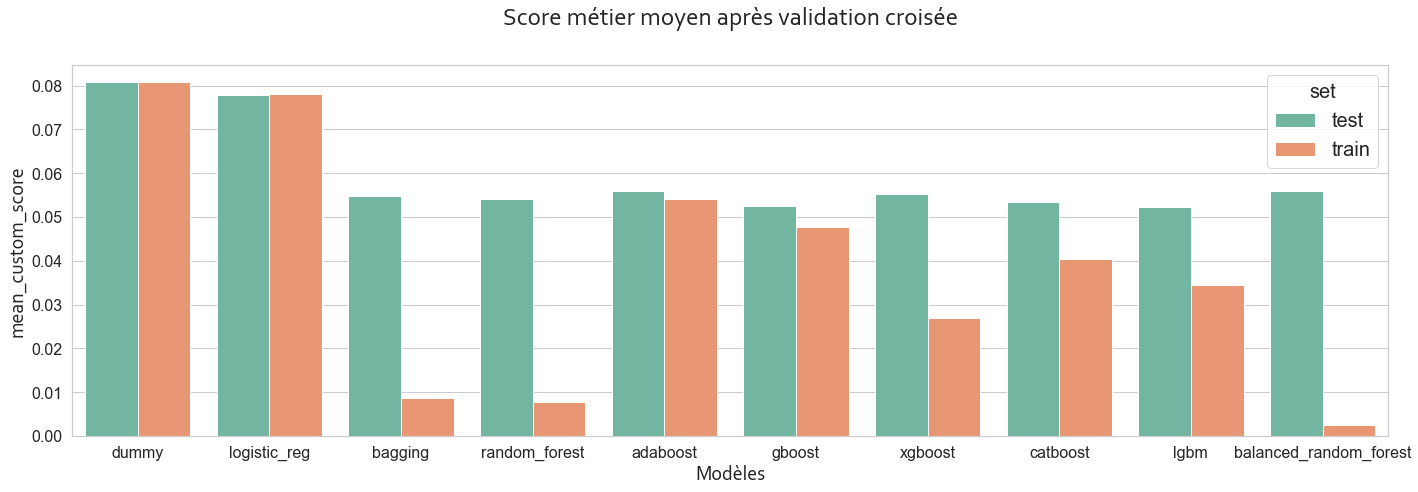

In [46]:
scores_copy = scores_cv.copy()
scores_copy['mean_custom_score'] = scores_copy['mean_custom_score'].abs()
titles = {"title": 'Score métier moyen après validation croisée', 'xlabel': 'Modèles'}
toolbox.display_barplot(scores_copy, 'model', 'mean_custom_score', titles, (20,7), 'set', True, 'Set2')

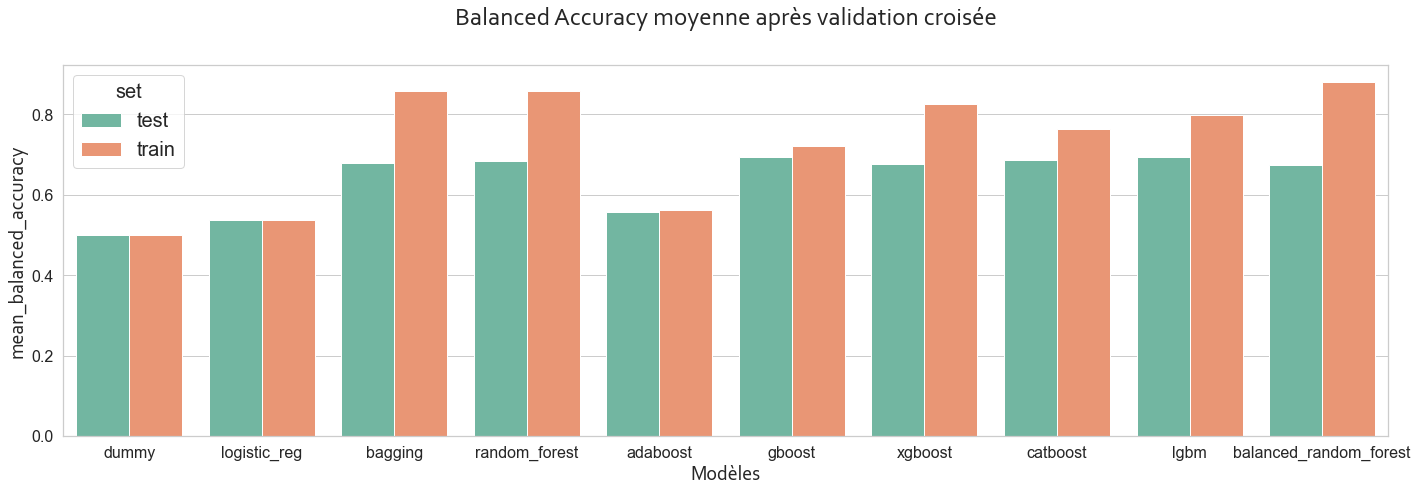

In [47]:
titles = {"title": 'Balanced Accuracy moyenne après validation croisée', 'xlabel': 'Modèles'}
toolbox.display_barplot(scores_copy, 'model', 'mean_balanced_accuracy', titles, (20,7), 'set', True, 'Set2')

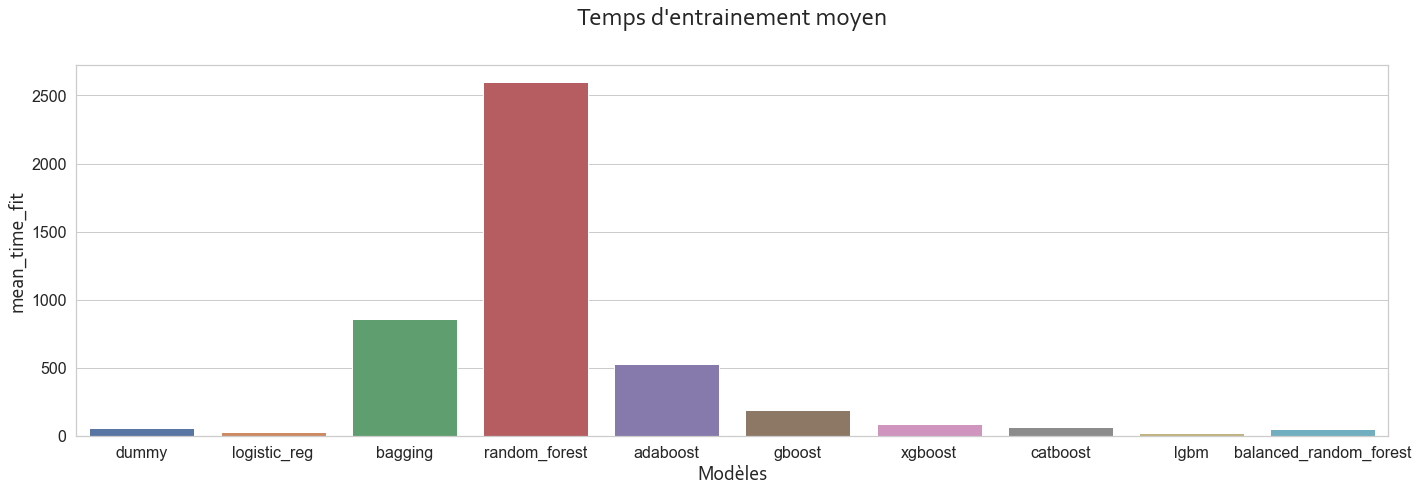

In [45]:
titles = {'title': 'Temps d\'entrainement moyen', 'xlabel': 'Modèles'}
toolbox.display_barplot(scores_copy, 'model', 'mean_time_fit', titles, (20,7))

<h3 style="font-family:Corbel Light; color:#737373">Optimisation</h3>

In [22]:
datasets = {'X_train': X_train, 
            'y_train': y_train.values.ravel(), 
            'X_test': X_test, 
            'y_test': y_test.values.ravel()}

In [20]:
binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
categ_features = [col for col in X_train.columns if X_train[col].dtype == 'object' and col not in binary_features]
numeric_features = X_train._get_numeric_data().columns

<h4 style="font-family:Corbel Light; color:#737373">Gradient Boost</h4>

In [23]:
# fonction à minimiser
def gb_cv(params, X: np.array, y: np.array, transformers: [dict], sampler: list, random_state=8, cv=3):
    clf = GradientBoostingClassifier(random_state=random_state, **params)
    model = build_model(clf, transformers, sampler)
    
    custom_score = make_scorer(custom_cost_score, needs_proba=True, greater_is_better=False)
    score = -cross_val_score(model, X, y, cv=cv, scoring=custom_score, n_jobs=-1).mean()

    return score 

In [84]:
print("score métier sans optimisation : {:.4f}\n".format(gb_cv({}, X_train, y_train, transformers_features, sampler)))

score métier sans optimisation : 0.0524



NameError: name 'partial' is not defined

In [27]:
space_gb={'n_estimators': scope.int(hp.quniform('n_estimators', 100, 500, 1)),
          'max_depth' : scope.int(hp.quniform('max_depth', 2, 5, 1)),
          'learning_rate': hp.loguniform('learning_rate',  np.log(0.1), np.log(0.7)), 
          'max_features' : hp.quniform('max_features', 0.5, 1.0, 0.1),
          #'n_iter_no_change' : scope.int(hp.quniform('n_iter_no_change', 5, 100, 1)), 
          'min_samples_leaf' : scope.int(hp.quniform('min_samples_leaf', 2, 5, 1)), 
          'min_samples_split' : scope.int(hp.quniform('min_samples_split', 2, 5, 1))
         }

In [28]:
%%time
trials_gb=Trials()
best_params_gb=fmin(fn=partial(gb_cv,X=X_train, y=y_train, transformers=transformers_features, sampler=sampler),
                    space=space_gb, 
                    algo=tpe.suggest,
                    max_evals=5,
                    trials=trials_gb,
                    rstate=np.random.default_rng(8),
                    #early_stop_fn=no_progress_loss(20)
                    )

100%|██████████| 5/5 [1:43:19<00:00, 1239.87s/trial, best loss: 0.054082150532955876]
CPU times: total: 18.4 s
Wall time: 1h 43min 26s


In [75]:
def score_best_model(classifier, transformers:[dict], best_params:dict, datasets: dict, sampler=[], 
                     cv=5, with_eval_set=False): 
    """
    Affiche R2 sur jeu de test/train + temps d'entrainement du modèle optimisé et retourne le modèle optimisé entrainé

    Positional arguments : 
    -------------------------------------
    regressors :  : modèle de régression optimisé
    transformers : list of dict : liste des transformations à appliquer sur les variables avant l'entrainement
    best_params : dict : dictionnaire des paramètres avec lesquels configurer le modèle optimisé
    datasets : dict : dictionnaire contenant les jeux de données de test et d'entrainement
    
    Optional arguments : 
    -------------------------------------
    cv : int : nombre de folds dans la validation croisée utilisée pour calculer l'écart type du R2 (pour voir la stabilité du modèle)
    """ 
    model_opt = build_model(classifier, transformers, sampler)
    custom_score = make_scorer(custom_cost_score, needs_proba=True, greater_is_better=False)
    #std = -cross_val_score(model_opt, datasets['X_train'], datasets['y_train'], cv=cv, scoring=custom_score, n_jobs=-1).std()
    
    t1_opt_start = perf_counter()
    
    if with_eval_set:
        x_train, x_valid, y_train, y_valid = train_test_split(datasets['X_train'], datasets['y_train'], test_size=0.3, 
                                                              random_state=8, stratify=datasets['y_train'])
        model_opt.fit(x_train, y_train, 
                      eval_set=[(x_train, y_train), (x_valid, y_valid)], 
                      eval_metric=custom_score)
    else :
        model_opt.fit(datasets['X_train'], datasets['y_train'])
        
    t1_opt_stop = perf_counter()
    
    y_pred = model_opt.predict_proba(datasets['X_train'])    
    score, thresh = custom_cost_score(datasets['y_train'], y_pred[:,1], return_thresh=True)
    y_pred_test = model_opt.predict_proba(datasets['X_test'])
    y_pred_test = (y_pred_test[:,1]>=thresh).astype('int')
    
    best_param_df = pd.DataFrame(best_params.items(), columns=['Param', 'Best Param'])
    best_param_df = pd.concat([best_param_df, pd.DataFrame([{'Param': 'thresh', 'Best Param': thresh}])])
    display(best_param_df)
    
    print("Modèle optimisé : ")
    print("Test Score métier : {:.4f}".format(cost(datasets['y_test'], y_pred_test)))
    print("Test AUC: {:.4f}".format(roc_auc_score(datasets['y_test'], y_pred_test)))
    print("Temps d'entrainement : {:.3f}".format(t1_opt_stop - t1_opt_start))
    print("Train Score métier : {:.4f}".format(score))
    
    #print("\nEcart type Score métier (validation croisée sur train set) : {:.4f}".format(std))
    
    return model_opt

In [52]:
best_model_gb = GradientBoostingClassifier(random_state=8, n_iter_no_change=5,
                                            n_estimators = int(best_params_gb['n_estimators']), 
                                            max_depth = int(best_params_gb['max_depth']), 
                                            learning_rate = best_params_gb['learning_rate'], 
                                            max_features= best_params_gb['max_features'],
                                            #n_iter_no_change=int(best_params_gb['n_iter_no_change']), 
                                            min_samples_leaf=int(best_params_gb['min_samples_leaf']),
                                            min_samples_split=int(best_params_gb['min_samples_split'])
                                            )

best_model_gb_fit = score_best_model(best_model_gb, transformers_features, best_params_gb, datasets, sampler)

,Param,Best Param
0,learning_rate,0.205795
1,max_depth,5.000000
2,max_features,0.900000
3,min_samples_leaf,5.000000
4,min_samples_split,3.000000
5,n_estimators,311.000000
0,thresh,0.535000


Modèle optimisé : 
Test Score métier : 0.0515
Temps d'entrainement : 173.443
Train Score métier : 0.0434


In [100]:
best_param_df = pd.DataFrame([['learning_rate', 0.205795], ['max_depth', 5.000000], ['max_features',0.900000], 
                              ['min_samples_leaf',5.000000], ['min_samples_split', 3.000000], ['n_estimators',311.000000], 
                             ['thresh', 0.535000]], columns=['Param', 'Best Param'])

In [133]:
path = 'C:/Users/Hermine/Documents/PoleEmploi/OpenClassRooms/FormationDataScientist/Projet 7/pythonProject'

In [134]:
best_param_df.to_pickle(path + 'BestParams.pkl')

In [111]:
best_param_df.loc[best_param_df['Param']=='thresh', 'Best Param'].values[0]

0.535

<h4 style="font-family:Corbel Light; color:#737373">LightGBM</h4>

In [20]:
transformers_features_nan = [{'feature': binary_features, 'estimator': [OrdinalEncoder(dtype=int)]}, 
                             {'feature': categ_features, 'estimator': [GetDummiesTransformer()]},
                             {'feature': numeric_features, 'estimator': [RobustScaler()]}
                             ]
sampler = [RandomUnderSampler(random_state=8)]

In [47]:
# fonction à minimiser
def lgbm_cv(params, X: np.array, y: np.array, transformers: [dict], sampler: list, random_state=8, cv=3):
    clf = LGBMClassifier(random_state=random_state, **params)
    model = build_model(clf, transformers, sampler)
    
    custom_score = make_scorer(custom_cost_score, needs_proba=True, greater_is_better=False)
    score = -cross_val_score(model, X, y, cv=cv, scoring=custom_score, n_jobs=-1).mean()

    return score 

In [46]:
space_lgbm={'n_estimators': scope.int(hp.quniform('n_estimators', 100, 500, 1)),
            'max_depth' : scope.int(hp.quniform('max_depth', 2, 10, 1)),
            'num_leaves': scope.int(hp.quniform('num_leaves', 2, 40, 1)),
            'learning_rate': hp.loguniform('learning_rate',  np.log(0.1), np.log(0.7)), 
            'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1.0), 
            'subsample' : hp.uniform('subsample', 0.5, 1.0), 
            'reg_alpha' : hp.uniform('reg_alpha', 0, 100), 
            'reg_lambda' : hp.uniform('reg_lambda', 0, 100), 
            'min_split_gain' : hp.uniform('min_split_gain', 0.5, 1.0), 
            'min_child_weight' : hp.uniform('min_child_weight', 0.5, 1.0), 
         }

In [ ]:
print("score métier sans optimisation : {:.4f}\n".format(lgbm_cv({}, X_train, y_train, transformers_features_nan, sampler)))

In [51]:
%%time
trials_lgbm=Trials()
best_params_lgbm=fmin(fn=partial(lgbm_cv,X=X_train, y=y_train, transformers=transformers_features_nan, sampler=sampler),
                      space=space_lgbm, 
                      algo=tpe.suggest,
                      max_evals=30,
                      trials=trials_lgbm,
                      rstate=np.random.default_rng(8),
                      #early_stop_fn=no_progress_loss(20)
                      )

 77%|███████▋  | 23/30 [1:37:42<37:18, 319.81s/trial, best loss: 0.05152796136492336]  

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



100%|██████████| 30/30 [2:04:43<00:00, 249.45s/trial, best loss: 0.05152796136492336]
CPU times: total: 1min 17s
Wall time: 2h 4min 45s


In [52]:
trials_df_lgbm = toolbox.build_trial_df(trials_lgbm, 'custom_score')
trials_df_lgbm.head()

,colsample_bytree,learning_rate,max_depth,min_child_weight,min_split_gain,n_estimators,num_leaves,reg_alpha,reg_lambda,subsample,custom_score,trial_number
0,0.574753,0.130866,3.0,0.580024,0.685442,499.0,35.0,93.907929,16.719938,0.763658,0.055017,0
1,0.857649,0.358596,5.0,0.601123,0.942414,346.0,39.0,16.816294,59.156873,0.644271,0.052383,1
2,0.832663,0.189914,4.0,0.762043,0.925481,322.0,27.0,32.270227,94.101465,0.824666,0.052864,2
3,0.793453,0.173670,3.0,0.840205,0.852331,226.0,26.0,97.325495,35.792373,0.866214,0.055541,3
4,0.520425,0.277999,8.0,0.994972,0.884234,324.0,25.0,61.003708,69.380290,0.653708,0.053654,4


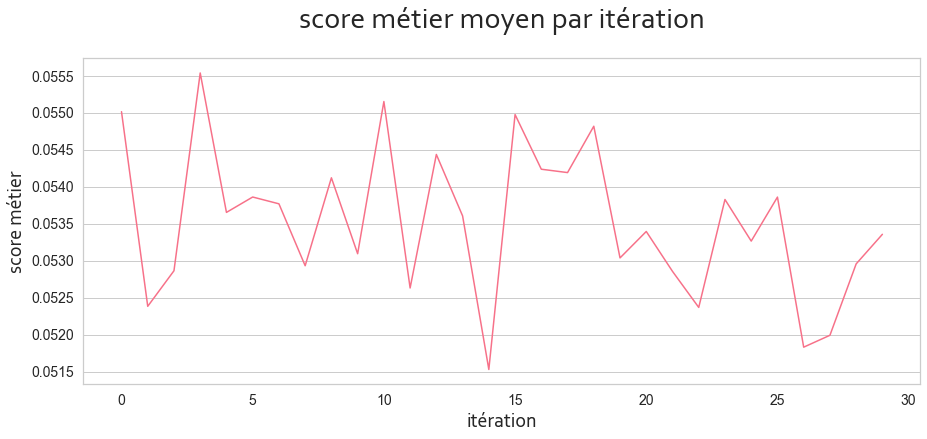

In [55]:
titles = {'title': 'score métier moyen par itération', 'xlabel': 'itération', 'ylabel': 'score métier'}
toolbox.display_lineplot(trials_df_lgbm, 'trial_number', 'custom_score', (15, 6), titles, grid_x=False)

In [78]:
best_model_lgbm = LGBMClassifier(random_state=8, #n_iter_no_change=5,
                                 n_estimators = int(best_params_lgbm['n_estimators']), 
                                 max_depth = int(best_params_lgbm['max_depth']), 
                                 learning_rate = best_params_lgbm['learning_rate'], 
                                 colsample_bytree = best_params_lgbm['colsample_bytree'],
                                 subsample = best_params_lgbm['subsample'],
                                 reg_alpha = best_params_lgbm['reg_alpha'],
                                 reg_lambda = best_params_lgbm['reg_lambda'],
                                 min_split_gain = best_params_lgbm['min_split_gain'],
                                 min_child_weight = best_params_lgbm['min_child_weight'],
                                 num_leaves = int(best_params_lgbm['num_leaves'])
                                )

best_model_lgbm_fit = score_best_model(best_model_lgbm, transformers_features_nan, best_params_lgbm, datasets, sampler, True)

,Param,Best Param
0,colsample_bytree,0.884904
1,learning_rate,0.349338
2,max_depth,7.000000
3,min_child_weight,0.927633
4,min_split_gain,0.594755
5,n_estimators,425.000000
6,num_leaves,3.000000
7,reg_alpha,2.028504
8,reg_lambda,98.164184
9,subsample,0.775639


Modèle optimisé : 
Test Score métier : 0.0499
Test AUC: 0.7088
Temps d'entrainement : 31.427
Train Score métier : 0.0461


In [23]:
best_model_lgbm = LGBMClassifier(random_state=8, #n_iter_no_change=5,
                                 n_estimators = int(425.000000), 
                                 max_depth = int(7.000000), 
                                 learning_rate = 0.349338, 
                                 colsample_bytree = 0.884904,
                                 subsample = 0.775639,
                                 reg_alpha = 2.028504,
                                 reg_lambda = 98.164184,
                                 min_split_gain = 0.594755,
                                 min_child_weight = 0.927633,
                                 num_leaves = int(3.000000)
                                )

best_model_lgbm_fit = build_model(best_model_lgbm, transformers_features_nan, sampler)
custom_score = make_scorer(custom_cost_score, needs_proba=True, greater_is_better=False)

x_train, x_valid, y_train, y_valid = train_test_split(datasets['X_train'], datasets['y_train'], test_size=0.3, 
                                                              random_state=8, stratify=datasets['y_train'])
best_model_lgbm_fit.fit(datasets['X_train'], datasets['y_train'])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(dtype=<class 'int'>))]),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('getdummiestransformer',
                                                                   <__main__.GetDummiesTransformer object at 0x000001C862B277C0>)]),
                                                  ['NA...
       'CC_SK_DPD_DEF_SUM', 'CC_SK_DPD_DEF_VAR', 'CC_COUNT'],
      dtype='object', length=420))])),
                ('randomundersampler', RandomUnderSampler(random_state=8)),
                ('lgbmclassifier',
                 LGBMClassifier(colsample_bytree=0.884904,
                                learning_rate=0.349338, max_depth=7,
                                min_child_weight=0.927633,
                                min_split_gain=0.594755, n_estimators=425,
                                num_leaves=3, random_state=8,
                                reg_alpha=2.028504, reg_lambda=98.164184,
                                subsample=0.775639))])

<h4 style="font-family:Corbel Light; color:#737373">Analyse importance des variables</h4>

In [99]:
binary_features =  best_model_lgbm_fit[0].named_transformers_['pipeline-1'][0].feature_names_in_

In [100]:
numeric_features =  best_model_lgbm_fit[0].named_transformers_['pipeline-3'][0].feature_names_in_

In [101]:
features_getdummies = best_model_lgbm_fit[0].named_transformers_['pipeline-2'][0].get_feature_names()
features_final = [*binary_features, *features_getdummies, *numeric_features]

In [103]:
len(features_final)

725

<Figure size 1656x720 with 0 Axes>

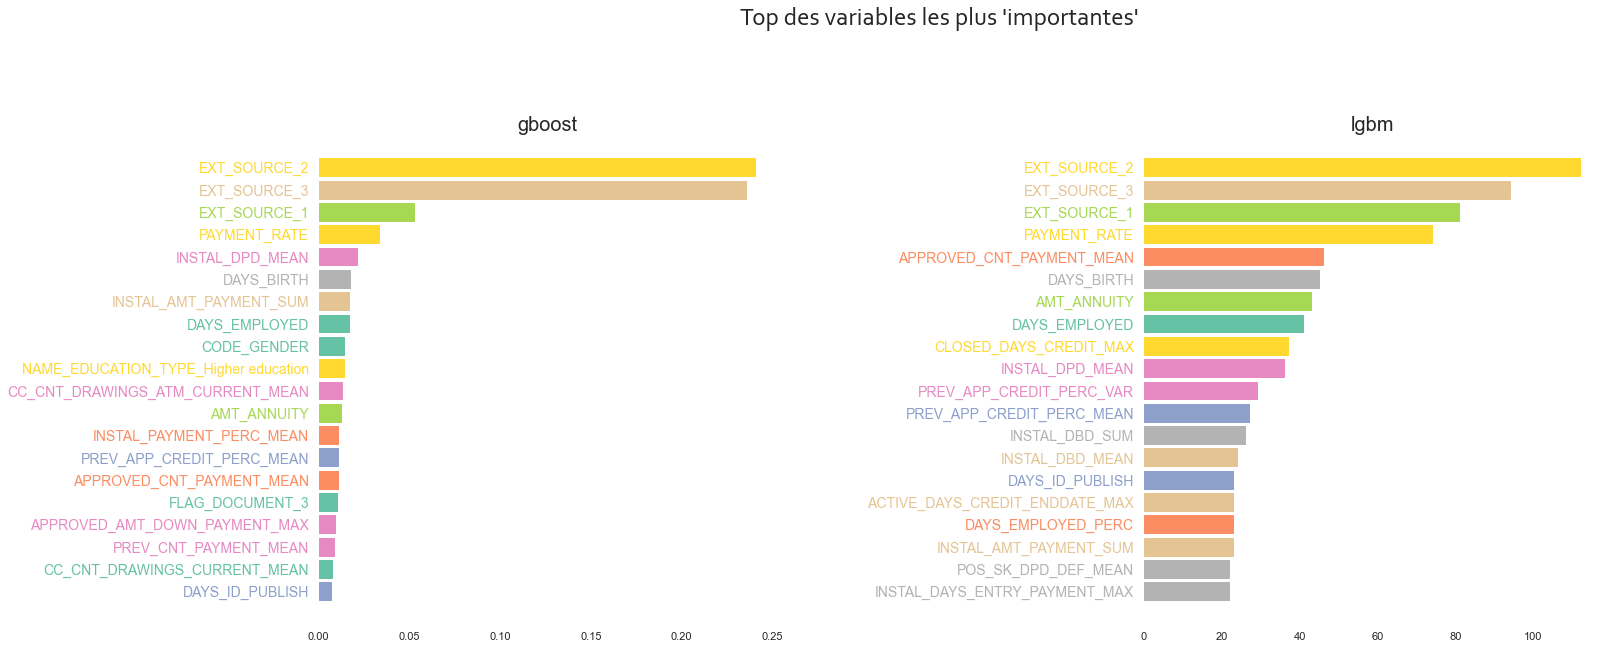

In [58]:
tree_models = []

classifiers = [{'name': 'gboost', 'classifier': GradientBoostingClassifier(random_state=8, n_estimators=100), 'transformers': transformers_features},
               {'name': 'lgbm', 'classifier': LGBMClassifier(random_state=8, n_estimators=100), 'transformers': transformers_features_nan}]

for model in classifiers: 
    clf = build_model(model['classifier'], model['transformers'], sampler)
    clf.fit(X_train, y_train.values.ravel())

    tree_models.append({"name": model['name'], "model": clf})
    

toolbox.plot_feature_importance_tree_model(tree_models, features_final, (23, 10), 20)

EXT_SOURCE = Normalized score from external data source,normalized

<h4 style="font-family:Corbel Light; color:#737373">SHAP (lightgbm)</h4>

La librairie shap permet notamment de visualiser l'impact de chaque variable sur la prédiction de notre choix.

Explain the result of calling predict_proba

In [21]:
t[:,1]

array([0.55154414, 0.37123709])

In [22]:
t

array([[0.44845586, 0.55154414],
       [0.62876291, 0.37123709]])

In [210]:
b.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT,DEFAULT_PROB,CLIENT_ID,SIZE,OPACITY
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
386902,Cash loans,M,Y,N,0,292500.0,1350000.0,39474.0,1350000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,0.551544,selected client,0.7,1.0
309336,Cash loans,M,Y,Y,2,157500.0,888840.0,29376.0,675000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,0.371237,other clients,0.1,0.5
233948,Cash loans,M,N,N,0,270000.0,900000.0,55062.0,900000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,0.536567,other clients,0.1,0.5
265098,Cash loans,F,N,N,0,112500.0,517500.0,16821.0,517500.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,44.0,0.642377,other clients,0.1,0.5
176395,Cash loans,F,N,Y,1,126000.0,549882.0,16209.0,459000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,0.380615,other clients,0.1,0.5


In [211]:
b.loc[[386902, 309336]]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT,DEFAULT_PROB,CLIENT_ID,SIZE,OPACITY
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
386902,Cash loans,M,Y,N,0,292500.0,1350000.0,39474.0,1350000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,0.551544,selected client,0.7,1.0
309336,Cash loans,M,Y,Y,2,157500.0,888840.0,29376.0,675000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,0.371237,other clients,0.1,0.5


In [212]:
numeric_features = best_model_lgbm_fit[0].named_transformers_['pipeline-3'][0].feature_names_in_

In [11]:
t = best_model_lgbm_fit.predict_proba(b)

In [12]:
b['DEFAULT_PROB'] = t[:,1]

In [4]:
b = a.iloc[:1_000].copy()

In [3]:
a = d.copy()

In [2]:
d = pd.read_pickle('X_sample.pkl')

In [13]:
import plotly.express as px

In [97]:
b['CLIENT_ID'] ="other clients"

In [98]:
b.loc[386902, 'CLIENT_ID'] = 'selected client'

In [16]:
import plotly.graph_objects as go

In [84]:
idx = b.index.tolist()
idx.remove(386902)
c = b.reindex(idx + [386902])

In [91]:
fig.data[0]

Scatter({
    'hovertemplate': ('CLIENT_ID=selected client<br>A' ... '%{marker.color}<extra></extra>'),
    'legendgroup': 'selected client',
    'marker': {'color': array([0.55154414]),
               'coloraxis': 'coloraxis',
               'opacity': array([1. , 0.2, 0.2, ..., 0.2, 0.2, 0.2]),
               'size': array([0.7]),
               'sizemode': 'area',
               'sizeref': 0.0017499999999999998,
               'symbol': 'circle'},
    'mode': 'markers',
    'name': 'selected client',
    'orientation': 'v',
    'showlegend': True,
    'x': array([39474.]),
    'xaxis': 'x',
    'y': array([-1062.]),
    'yaxis': 'y'
})

In [ ]:
['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
             'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
             'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
             'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
             'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
             'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
             'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
             'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
             'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
             'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
             'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
             'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
             'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
             'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
             'ylorrd'].

In [4]:
client_id = client_database.index.tolist()[0]
n_neighbors = 10

In [ ]:
#fig.add_trace(go.Scatter(mode='markers', x=[b.loc[386902, 'AMT_ANNUITY']], y=[b.loc[386902, 'DAYS_EMPLOYED']], 
                         #marker=dict(size=15, color=np.array([0.55154414]), symbol='diamond', 
                         #line=dict(color='DarkSlateGrey', width=2)), name='selected client'))

 .9

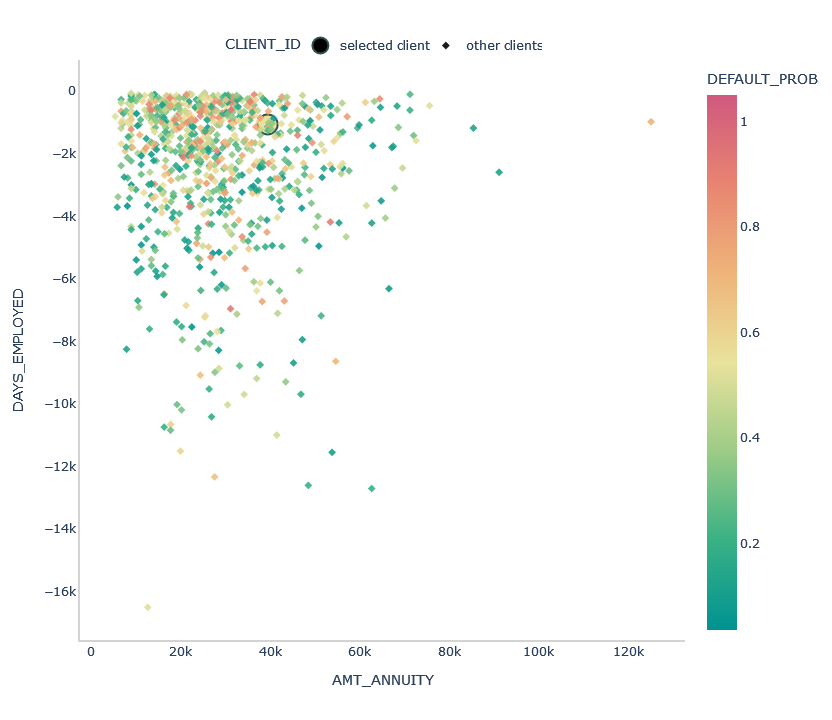

In [209]:
fig = px.scatter(b, x='AMT_ANNUITY', y='DAYS_EMPLOYED', color='DEFAULT_PROB', symbol='CLIENT_ID', opacity=.9,
                 color_continuous_scale='temps')
fig.update_traces(marker=dict(size=20, line=dict(color='DarkSlateGrey', width=2), opacity=1), selector=({"name": 'selected client'})) #name='selected client')
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", xanchor="center", y=1, x=.5), plot_bgcolor='white')
fig.update_xaxes(gridcolor='lightgrey', linecolor='lightgrey', linewidth=2, showline=True, showgrid=False)
fig.update_yaxes(gridcolor='lightgrey', linecolor='lightgrey', linewidth=2, showline=True, showgrid=False)
fig.show()

In [28]:
!pip install more-itertools

     -------------------------------------- 54.2/54.2 kB 472.8 kB/s eta 0:00:00


In [7]:
import requests

In [11]:
URL_API = "http://127.0.0.1:8000/"

In [ ]:
print(client.get("/", params={"data": ["3", "4"]}))

In [30]:
import more_itertools as mit

In [59]:
chunk_list = list(mit.chunked(a.index.tolist(), 1_000))

In [56]:
len(chunk_list)

31

In [62]:
%%time
results = []
for chunk in chunk_list:
    params = {'client_ids': chunk}
    response = requests.get(URL_API + 'predict_default_all_clients', params=params)
    #print(response.status_code)
    results.extend(response.json()['proba_default'])

CPU times: total: 10.6 s
Wall time: 1min 10s


In [61]:
for chunk in chunk_list[9:18]:
    params = {'client_ids': chunk}
    response = requests.get(URL_API + 'predict_default_all_clients', params=params)
    print(response.status_code)
    results.extend(response.json()['proba_default'])

200
200
200
200
200
200
200
200
200


In [27]:
from itertools import islice

In [36]:
params = {'client_ids': a.index.tolist()[:8000]}
response = requests.get(URL_API + 'predict_default_all_clients', params=params)
response.status_code

200

In [44]:
result.extend(response.json()['proba_default'])

In [262]:
response.close()

In [ ]:
response.json()['proba_default']

In [6]:
import dill

In [5]:
path = 'C:/Users/Hermine/Documents/PoleEmploi/OpenClassRooms/FormationDataScientist/Projet 7/pythonProject'

In [7]:
pickle_in = open(path + "/classifier.pkl", "rb")
best_model_lgbm_fit = dill.load(pickle_in)

In [8]:
from warnings import simplefilter
simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [32]:
explainer = shap.TreeExplainer(best_model_lgbm_fit[-1], model_outpout='predict_proba')

#X_test_transformed = best_model_lgbm_fit[0].transform(X_test)
#y_test_pred = best_model_lgbm_fit.predict_proba(X_test)

In [35]:
transf = best_model_lgbm_fit[0].transform(X_test.loc[[215797]])

In [36]:
y_test_pred = best_model_lgbm_fit.predict_proba(X_test.loc[[215797]])

In [37]:
shap_vals = explainer.shap_values(transf)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [86]:
shap_values_explaination = shap.Explanation(shap_vals[1], base_values = explainer.expected_value[1], feature_names=features_final)

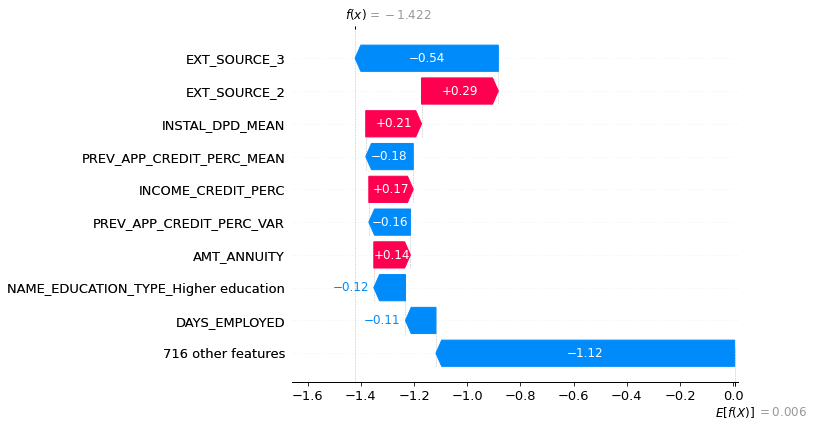

In [87]:
shap.plots.waterfall(shap_values_explaination[0])

In [89]:
np.exp(0.00000000e+00)/(1 + np.exp(0.00000000e+00))

0.5

In [62]:
shap_vals_p = np.exp(shap_vals)/(1 + np.exp(shap_vals))

In [79]:
shap_vals_p

array([[[0.52047933, 0.5       , 0.49419476, ..., 0.5       ,
         0.5       , 0.5       ]],

       [[0.47952067, 0.5       , 0.50580524, ..., 0.5       ,
         0.5       , 0.5       ]]])

In [64]:
expected_value_p = np.exp(explainer.expected_value)/(1 + np.exp(explainer.expected_value))

In [82]:
expected_value_p

array([0.49850124, 0.50149876])

In [90]:
shap_values_explaination = shap.Explanation(shap_vals[1], base_values = expected_value_p[1], feature_names=features_final)

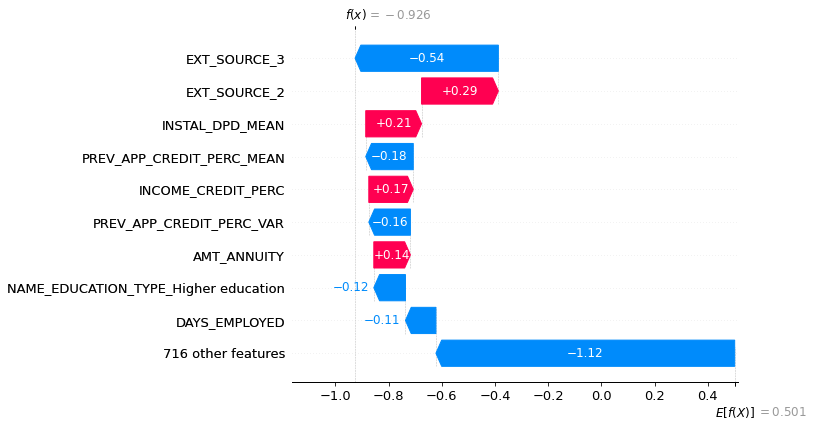

In [91]:
shap.plots.waterfall(shap_values_explaination[0])

In [92]:
np.array(expected_value_p) + np.array([shap_vals_p[0].sum(), shap_vals_p[1].sum()])

array([363.35270944, 362.64729056])

In [72]:
sample_idx = 806

#shap_vals = explainer.shap_values(X_test_transformed[sample_idx:sample_idx+1])

print("Expected/Base Value : ", explainer.expected_value)
#print("\nShap Values for Sample %d : "%sample_idx, shap_vals)

print("\nPrediction From Model                            : ", y_test_pred)
log_odds = np.array(explainer.expected_value) + np.array([shap_vals[0].sum(), shap_vals[1].sum()])
print("Prediction From Adding SHAP Values to Base Value : ", np.exp(log_odds)/(1 + np.exp(log_odds)))

Expected/Base Value :  [-0.005995046471776239, 0.005995046471776239]

Prediction From Model                            :  [[0.80559249 0.19440751]]
Prediction From Adding SHAP Values to Base Value :  [0.80559249 0.19440751]


In [18]:
from warnings import simplefilter
simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [16]:
client_database = pd.read_pickle('X_sample.pkl')

In [20]:
client_info = client_database.loc[[215797]]
explainer = shap.TreeExplainer(best_model_lgbm_fit[-1], model_outpout='predict_proba')

binary_features = best_model_lgbm_fit[0].named_transformers_['pipeline-1'][0].feature_names_in_
dummies_features = best_model_lgbm_fit[0].named_transformers_['pipeline-2'][0].get_feature_names()
numeric_features = best_model_lgbm_fit[0].named_transformers_['pipeline-3'][0].feature_names_in_

features = [*binary_features, *dummies_features, *numeric_features]

client_info_transformed = best_model_lgbm_fit[0].transform(client_info)
shap_vals = explainer.shap_values(client_info_transformed)
expected_values = explainer.expected_value

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [27]:
json.dumps(expected_values)

'[-0.005995046471776239, 0.005995046471776239]'

In [21]:
import requests
import json

In [31]:
y = {"shap_values": json.dumps(shap_vals[1].tolist()),
     "expected_values": expected_values[1],
     "features": features}

In [39]:
t = np.asarray(json.loads(y['shap_values']))

In [41]:
shap_values_explaination = shap.Explanation(t, base_values = y['expected_values'], feature_names=y['features'])

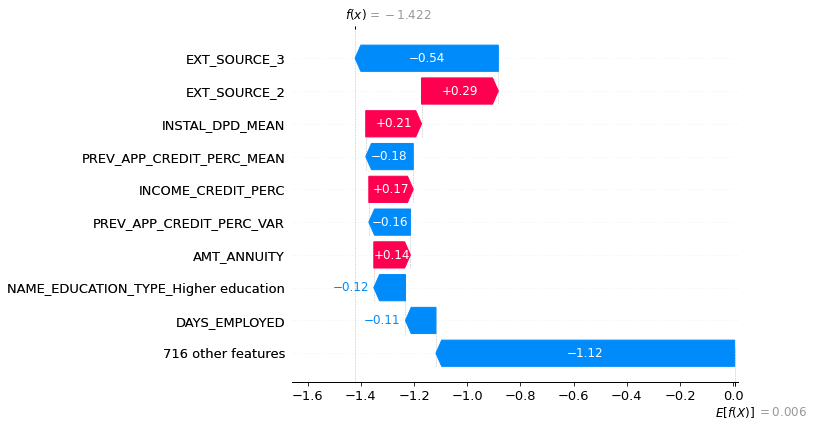

In [48]:
fig, ax = plt.subplots()
ax = shap.plots.waterfall(shap_values_explaination[0])
plt.show()

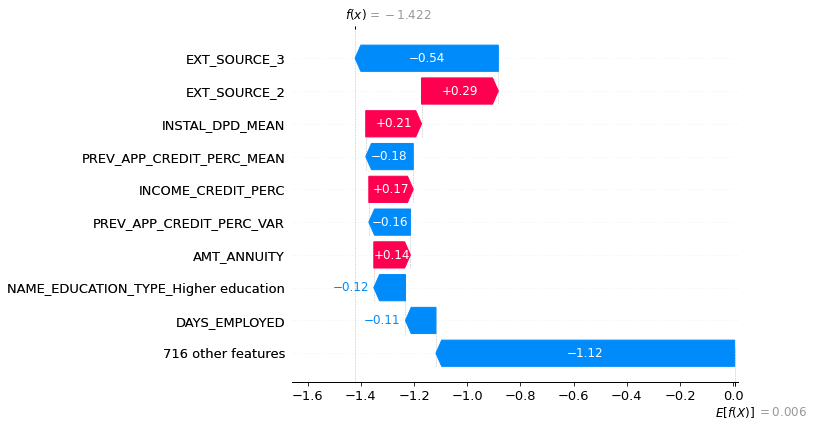

In [42]:
shap.plots.waterfall(shap_values_explaination[0])

In [2]:
import requests

In [3]:
url = "http://127.0.0.1:8000/download_database"
params = {"client_id": 215797}
response = requests.get(url)
print('status code:', response.status_code)

status code: 200


In [5]:
response.headers

{'date': 'Wed, 14 Jun 2023 11:40:44 GMT', 'server': 'uvicorn', 'content-type': 'application/pickle', 'content-disposition': 'attachment; filename="X_sample.pkl"', 'content-length': '547794201', 'last-modified': 'Sun, 11 Jun 2023 16:05:13 GMT', 'etag': 'a3f88855e55abe18dd74211bd63b7500'}

In [9]:
open('database.pkl', "wb").write(response.content)

547794201

In [10]:
X = pd.read_pickle('database.pkl')

In [11]:
X.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
386902,Cash loans,M,Y,N,0,292500.0,1350000.0,39474.0,1350000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309336,Cash loans,M,Y,Y,2,157500.0,888840.0,29376.0,675000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233948,Cash loans,M,N,N,0,270000.0,900000.0,55062.0,900000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265098,Cash loans,F,N,N,0,112500.0,517500.0,16821.0,517500.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0
176395,Cash loans,F,N,Y,1,126000.0,549882.0,16209.0,459000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
X[['AGE']].describe()

,AGE
count,153753.000000
mean,43.420206
std,11.936823
min,21.000000
25%,34.000000
50%,43.000000
75%,53.000000
max,68.000000


In [13]:
t = X.loc[[215797]]

In [17]:
t['DAYS_BIRTH'] // 365.25

SK_ID_CURR
215797   -63.0
Name: DAYS_BIRTH, dtype: float64

In [19]:
X['AGE'] = X['DAYS_BIRTH'].abs() // 365.25

In [74]:
t = (23, 56)

In [75]:
t[0]

23

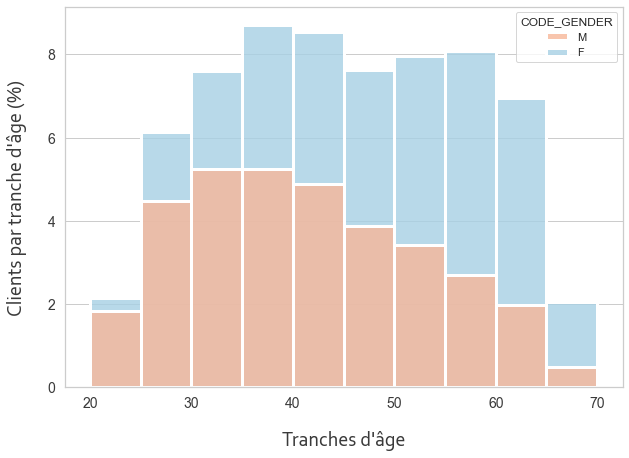

In [73]:
rgb_text = sns.color_palette('Greys', 15)[12]
sns.set_theme(style='whitegrid')
plt.figure(figsize=(10, 7))
ax = sns.histplot(data=X, x='AGE', hue='CODE_GENDER', binwidth=5, 
             stat="percent", binrange=[20, 70], alpha=.8, palette='RdBu', linewidth=3)

ax.set_xlabel("Tranches d'âge", labelpad=20, fontsize=20, fontname='Corbel', color=rgb_text)
ax.set_ylabel("Clients par tranche d'âge (%)", labelpad=20, fontsize=20, fontname='Corbel', color=rgb_text)
plt.tick_params(axis='both', which='major', labelsize=14, labelcolor=rgb_text)
plt.grid(False, axis='x')
plt.show()

In [52]:
215797 in X.index

True

In [8]:
np.asarray(response.json()['expected_values'])

array('0.005995046471776239', dtype='<U20')

In [ ]:
shap_values = np.asarray(response.json()['shap_values'])
base_values = np.asarray(response.json()['expected_values'])

In [73]:
print("Prediction From Adding SHAP Values to Base Value : ", log_odds )

Prediction From Adding SHAP Values to Base Value :  [ 1.4216215 -1.4216215]


In [31]:
sample_idx = 806

shap_vals = explainer.shap_values(X_test_transformed[sample_idx:sample_idx+1])

print("Expected/Base Value : ", explainer.expected_value)
#print("\nShap Values for Sample %d : "%sample_idx, shap_vals)

print("\nPrediction From Model                            : ", y_test_pred[sample_idx:sample_idx+1][0])
log_odds = np.array(explainer.expected_value) + np.array([shap_vals[0].sum(), shap_vals[1].sum()])
print("Prediction From Adding SHAP Values to Base Value : ", np.exp(log_odds)/(1 + np.exp(log_odds)))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Expected/Base Value :  [-0.005995046471776239, 0.005995046471776239]

Prediction From Model                            :  [0.86798658 0.13201342]
Prediction From Adding SHAP Values to Base Value :  [0.86798658 0.13201342]


In [101]:
X_test.iloc[sample_idx:sample_idx+1]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
429140,Cash loans,F,N,Y,0,157500.0,454500.0,19386.0,454500.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0


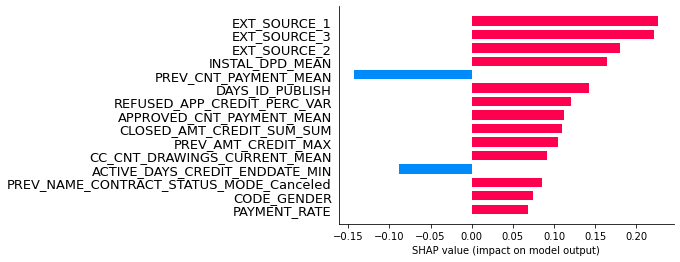

In [37]:
shap.bar_plot(shap_vals[0][0], feature_names=features_final, max_display=15)

In [41]:
shap_values_explaination = shap.Explanation(shap_vals[0], base_values = explainer.expected_value[0], feature_names=features_final)

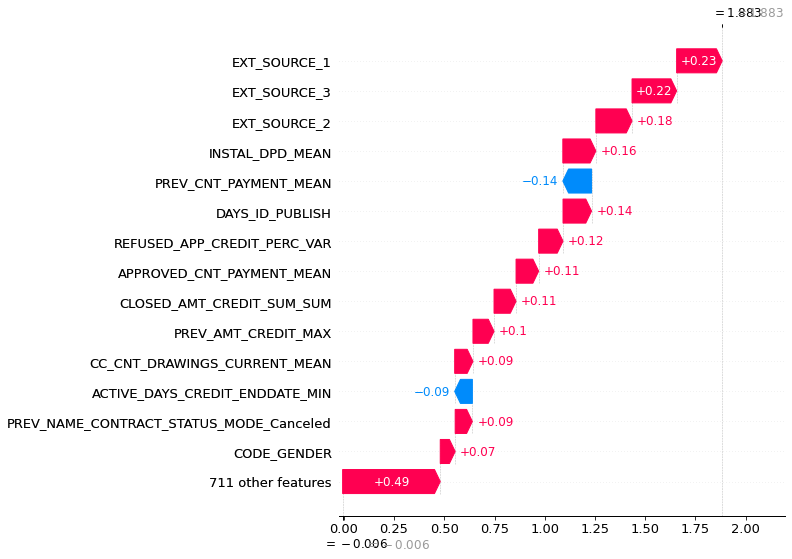

In [57]:
shap.plots.waterfall(shap_values_explaination[0])

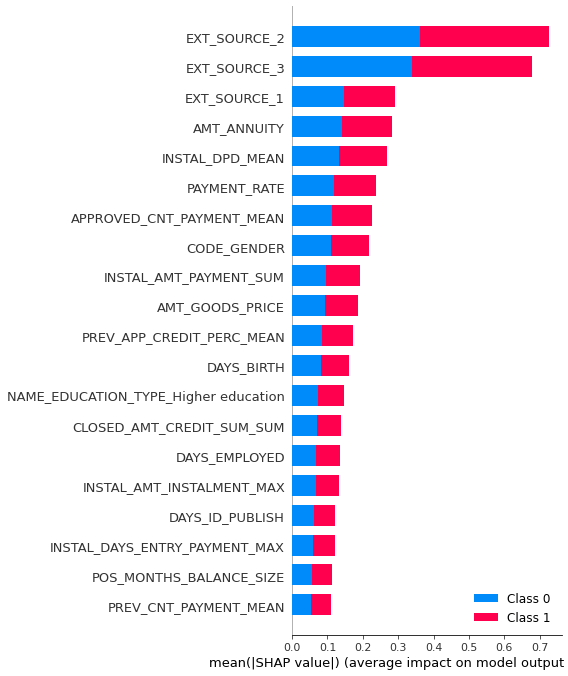

In [33]:
shap.summary_plot(explainer.shap_values(X_test_transformed),
                  features = X_test_transformed,
                  feature_names=features_final)

<h3 style="font-family:Corbel Light; color:#737373">Enregistre le modèle</h3>

In [58]:
import pickle

In [41]:
import dill

In [25]:
path = 'C:/Users/Hermine/Documents/PoleEmploi/OpenClassRooms/FormationDataScientist/Projet 7/pythonProject'
pickle_out = open(path + "/classifier.pkl", "wb")
dill.dump(best_model_lgbm_fit, pickle_out)
pickle_out.close()

In [118]:
t = X_test.loc[[215797]]

In [123]:
t

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
215797,Cash loans,F,N,Y,0,112500.0,1350000.0,45369.0,1350000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
t = [[0.80559249, 0.19440751]]

In [69]:
type(t)

numpy.ndarray

In [68]:
t = np.ndarray(shape=(2,), buffer=np.array([0.80559249, 0.19440751]))

In [72]:
t[1]

0.19440751

In [73]:
pickle_in = open("classifier.pkl", "rb")
classifier = dill.load(pickle_in)

In [75]:
from warnings import simplefilter
simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
p = classifier.predict_proba(X_test.loc[[215797]])

In [88]:
p[:,1]

array([0.19440751])

In [126]:
t['NAME_CONTRACT_TYPE'].values[0]

'Cash loans'

In [49]:
y.items()

dict_items([('0.8055924910300151', 0.19440750896998496)])

In [30]:
y = {"0.8055924910300151": 0.19440750896998496}

In [55]:
list(y.values())

0.19440750896998496

In [60]:
np.array(list(y.items()))[0][0]

'0.8055924910300151'

In [116]:
p[:,1]

array([0.19440751])

In [115]:
p[:,1]

array([0.80559249, 0.19440751])

In [20]:
int(np.round(0.8764*100))

88

<h3 style="font-family:Corbel Light; color:#737373">Nearest Neighbors</h3>

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
client_database = pd.read_pickle('X_sample.pkl')

In [7]:
binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
categ_features = [col for col in client_database.columns if client_database[col].dtype == 'object' and col not in binary_features]
numeric_features = client_database._get_numeric_data().columns

In [11]:
transformers_features = [{'feature': binary_features, 'estimator': [OrdinalEncoder(dtype=int)]}, 
                         {'feature': categ_features, 'estimator': [GetDummiesTransformer()]},
                         {'feature': numeric_features, 'estimator': [SimpleImputer(missing_values=np.nan, strategy='median'), RobustScaler()]}
                        ]

In [12]:
preprocessor = make_preprocessor(transformers_features)
neighbors = make_pipeline(preprocessor, NearestNeighbors(n_neighbors=10))

In [13]:
neighbors_fit = neighbors.fit(client_database)

In [19]:
transformed_data = neighbors_fit[0].transform(client_database.loc[[client_id]])

In [38]:
indices = neighbors_fit[1].kneighbors(transformed_data, n_neighbors= 20, return_distance=False)

In [39]:
indices[0].tolist()

[0,
 442,
 4231,
 75721,
 112615,
 86434,
 17463,
 4775,
 91241,
 72797,
 47208,
 43018,
 141924,
 79076,
 147960,
 1967,
 102113,
 12941,
 55014,
 30897]

In [40]:
client_database.iloc[indices[0].tolist()]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
386902,Cash loans,M,Y,N,0,292500.0,1350000.0,39474.0,1350000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115446,Cash loans,M,Y,Y,1,180000.0,755190.0,36459.0,675000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362884,Cash loans,F,Y,Y,0,112500.0,513531.0,35739.0,459000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
387943,Cash loans,M,Y,Y,0,225000.0,835380.0,40320.0,675000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293029,Cash loans,M,Y,Y,0,112500.0,783927.0,40153.5,688500.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367252,Cash loans,M,Y,N,0,135000.0,1078200.0,31522.5,900000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369889,Cash loans,F,N,Y,0,90000.0,900000.0,26446.5,900000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341320,Cash loans,M,Y,Y,0,247500.0,1006920.0,40063.5,900000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
394630,Cash loans,M,Y,Y,0,112500.0,1107981.0,29358.0,967500.0,Family,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
path = 'C:/Users/Hermine/Documents/PoleEmploi/OpenClassRooms/FormationDataScientist/Projet 7/pythonProject'
pickle_out = open(path + "/nearest_neighbors.pkl", "wb")
dill.dump(neighbors_fit, pickle_out)
pickle_out.close()

In [43]:
pickle_in = open(path + "/nearest_neighbors.pkl", "rb")
nn = dill.load(pickle_in)

In [44]:
transformed_data = nn[0].transform(client_database.loc[[client_id]])
indices = nn[1].kneighbors(transformed_data, return_distance=False)

In [45]:
indices[0].tolist()

[0, 442, 4231, 75721, 112615, 86434, 17463, 4775, 91241, 72797]

In [49]:
np.arange(1, client_database.shape[0], 50)

array([    10,     50,     90, ..., 153650, 153690, 153730])

In [47]:
client_database.iloc[indices[0].tolist()].index.tolist()

[386902,
 115446,
 362884,
 387943,
 293029,
 367252,
 369889,
 341320,
 394630,
 301161]

In [51]:
import requests

In [50]:
URL_API = "http://127.0.0.1:8000/"

In [56]:
params = {'client_id': 386902, 'n_neighbors': 10}
response = requests.get(URL_API + 'nearest_neighbors_ids', params=params)
response.status_code
#store_request(datetime.now(), response, str(params), "GET_nearest_neighbors_ids")

200

In [53]:
response.content

b'Internal Server Error'